# BUSINESS QUESTION

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import inflection
import math
import datetime
import random
import pickle
import warnings
import json
import os
import requests

from tabulate               import tabulate
from matplotlib.gridspec    import GridSpec
from IPython.display        import Image
from scipy                  import stats
from boruta                 import BorutaPy
from matplotlib             import pyplot as plt

from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

C:\Users\samue\anaconda3\envs\rossmann_ds_producao\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()  
    return None


def cramer_v( x, y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape 
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
        
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )


def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0] )


def cross_validation( xtraining, kfold, model_name, model, verbose=False ):
    mae_list= []
    mape_list= []
    rmse_list= []

    for k in reversed( range(1, kfold+1) ):
        if verbose:
            print( f'KFold number: {k}')

        # start and end date for validation
        validation_start_date =  x_training['date'].max() - datetime.timedelta( days= k*6*7)
        validation_end_date =  x_training['date'].max() - datetime.timedelta( days= (k-1)*6*7)

        # filtering dataset
        training =  x_training[ x_training['date'] < validation_start_date ]
        validation =  x_training[ (x_training['date'] > validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # predict
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) )
        m_result

        # store performance of eack kfold iteration
        mae_list.append( m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append( m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
        'MAE CV': np.round(np.mean( mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean( mape_list), 2).astype(str) +  ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean( rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str) }, index=[0] )

In [3]:
jupyter_settings()

## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv('C:\\Users\\samue\\Documents\\repos\\ds_em_producao\\data\\store.csv', low_memory= False)
df_train_raw = pd.read_csv('C:\\Users\\samue\\Documents\\repos\\ds_em_producao\\data\\train.csv', low_memory= False)

df_raw = pd.merge(df_sales_raw, df_train_raw, how='left', on= 'Store')

# 1.0. STEP 01 - DATA DESCRIPTIONS



In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

snakecase = lambda x: inflection.underscore(x)

new_cols = list( map( snakecase, cols_old) )

#rename
df1.columns = new_cols

## 1.2 Data Dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [8]:
## 1.3 Data Types
df1['date'] = pd.to_datetime( df1['date'] )

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 1.5 Fillout NA

In [10]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec' }

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1 )


In [11]:
df1.isna().sum()

store                           0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Attributes

In [13]:
num_attributes = df1.select_dtypes( include= ['float64', 'int64'] )
cat_attributes = df1.select_dtypes( exclude= ['float64', 'int64', 'datetime64[ns]'] )

m = num_attributes.agg( ['mean', 'median', 'std', 'min', 'max', 'ptp', 'skew', 'kurtosis'] ).T.reset_index().rename(columns = {'index': 'attributes', 'ptp': 'range'} )

m


,attributes,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908651,1.0,1115.0,1114.0,-0.000955,-1.200524
1,competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,199980.0,10.242344,147.789712
2,competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,11.0,-0.042076,-1.232607
3,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,115.0,-7.235657,124.071304
4,promo2,0.500564,1.0,0.500000,0.0,1.0,1.0,-0.002255,-1.999999
5,promo2_since_week,23.619033,22.0,14.310064,1.0,52.0,51.0,0.178723,-1.184046
6,promo2_since_year,2012.793297,2013.0,1.662658,2009.0,2015.0,6.0,-0.784436,-0.210075
7,day_of_week,3.998341,4.0,1.997391,1.0,7.0,6.0,0.001593,-1.246873
8,sales,5773.818972,5744.0,3849.926175,0.0,41551.0,41551.0,0.641460,1.778375
9,customers,633.145946,609.0,464.411734,0.0,7388.0,7388.0,1.598650,7.091773


C:\Users\samue\AppData\Local\Temp\ipykernel_3680\4199678138.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['sales'] )


<AxesSubplot:xlabel='sales', ylabel='Density'>

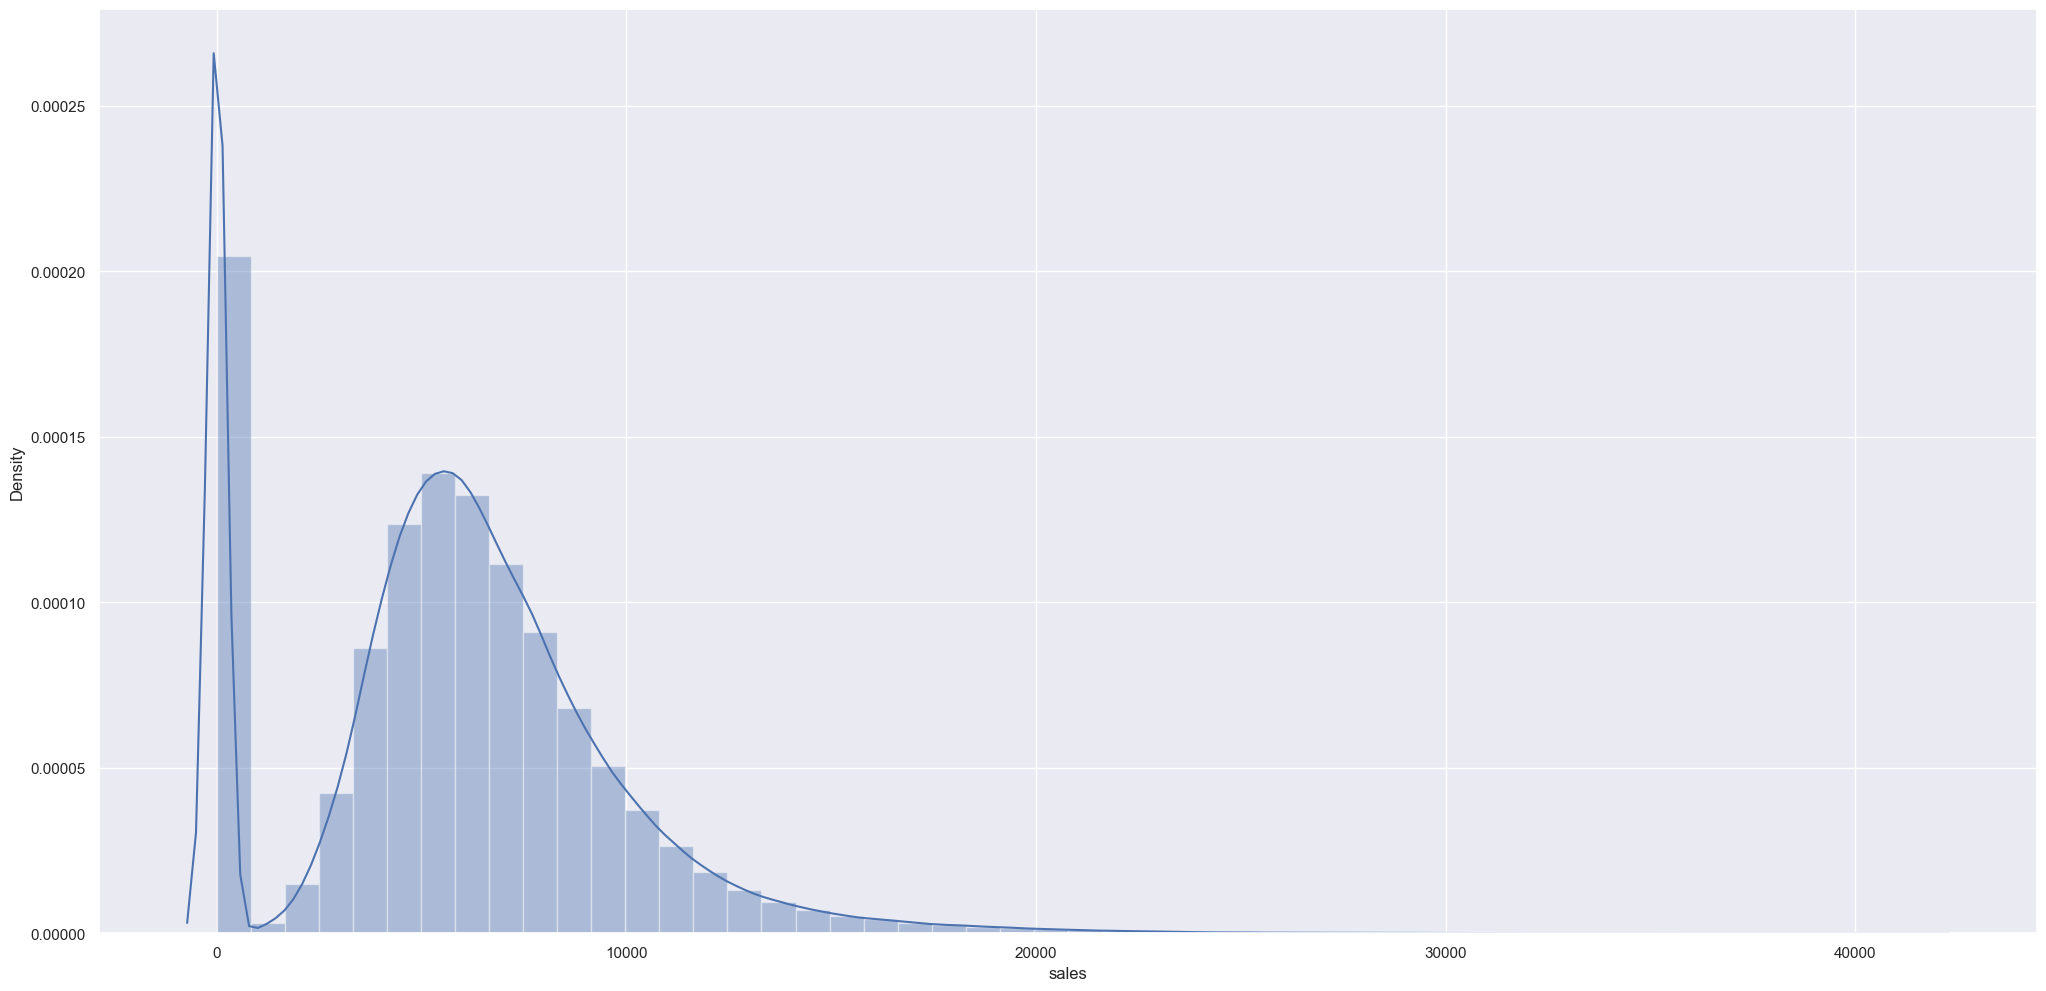

In [14]:
sns.distplot( df1['sales'] )

### 1.7.2 Categorical Attributes


In [15]:
# check len of each variable
cat_attributes.apply( lambda x: x.unique().shape[0] )

store_type         4
assortment         3
promo_interval     4
state_holiday      4
month_map         12
dtype: int64

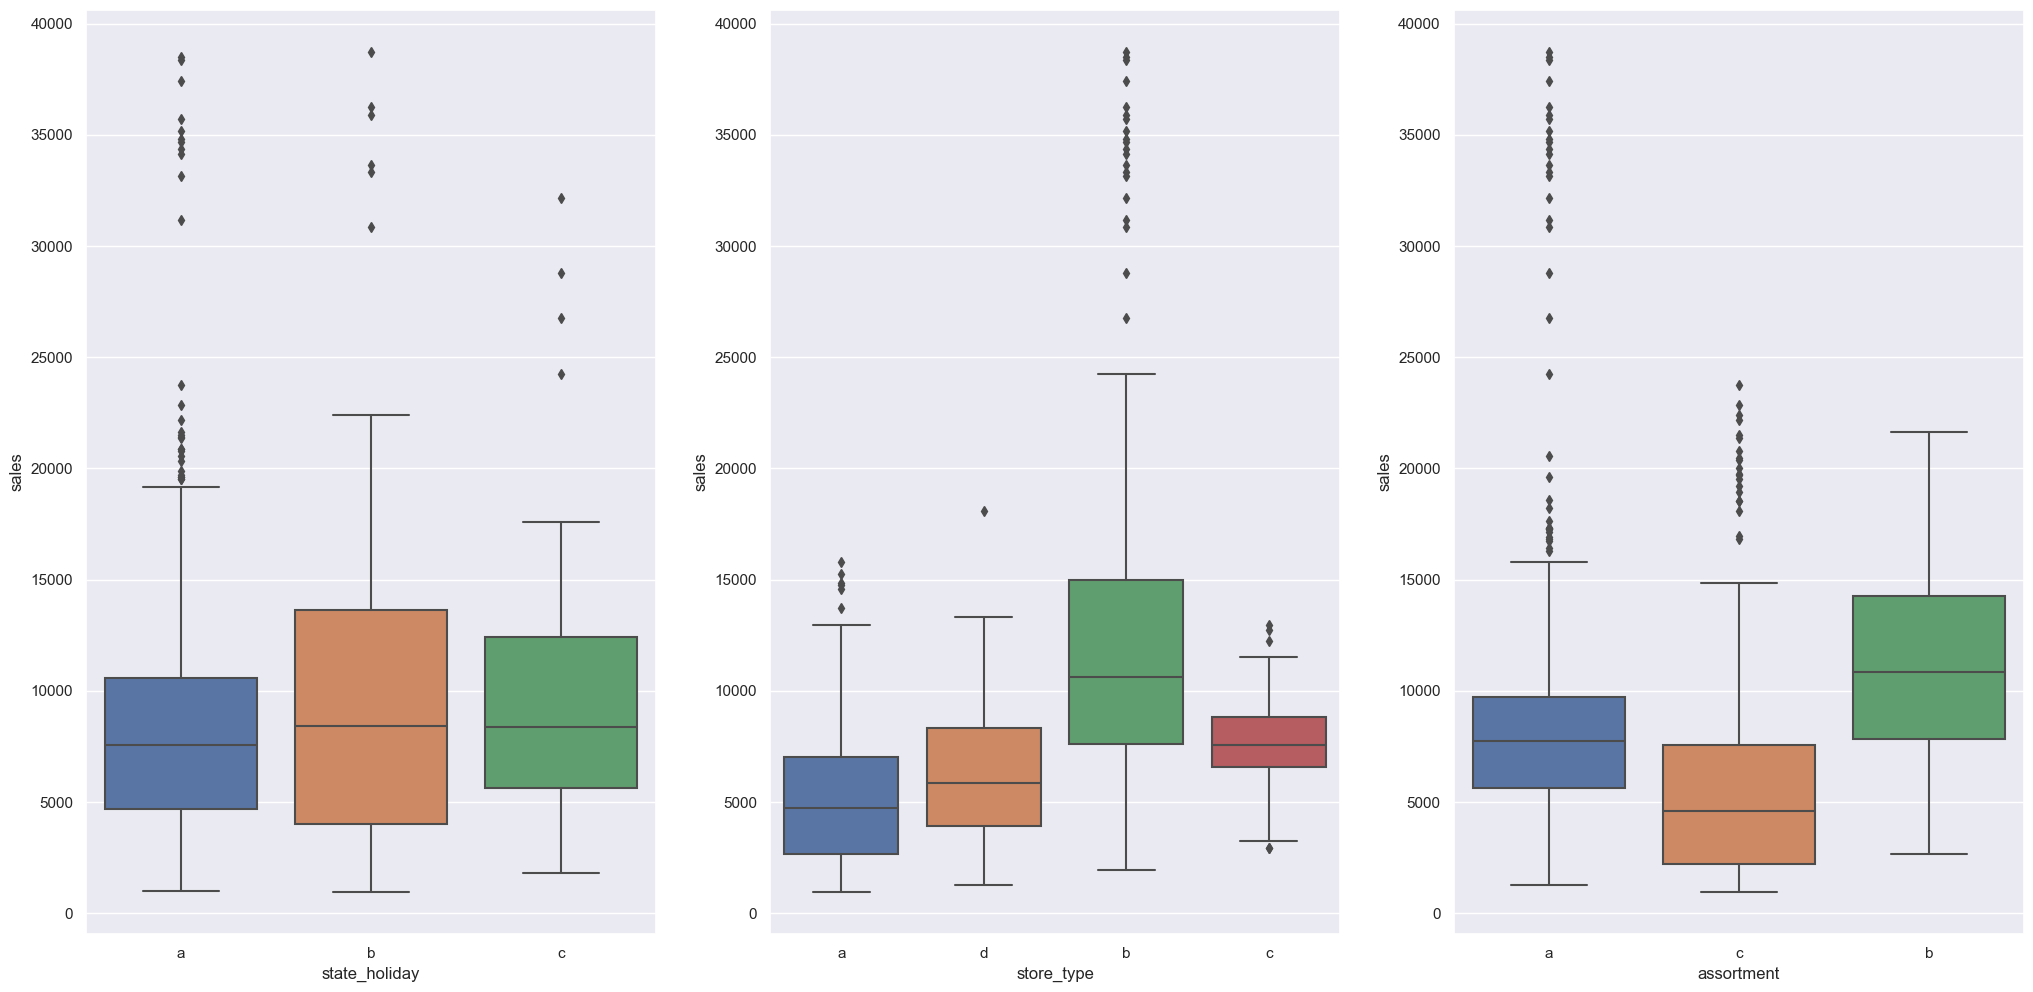

In [16]:
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

plt.subplot(1,3,1)
sns.boxplot( data = aux1, x='state_holiday', y='sales');

plt.subplot(1,3,2)
sns.boxplot( data = aux1, x='store_type', y='sales');

plt.subplot(1,3,3)
sns.boxplot( data = aux1, x='assortment', y='sales');

# 2.0. STEP 02 - FEATURE ENGINEERING


In [13]:
df2 = df1.copy()

## 2.1. Criação das Hipóteses

**Qual fenômeno estou modelando?** -> As vendas

**Agentes:** Quais agentes atuam sobre o fenômeno vendas? -> Produtos, Lojas, Clientes

**Atributos dos agentes:** Como os agentes são descritos? -> Ex.: Clientes: idade, sexo, salario...

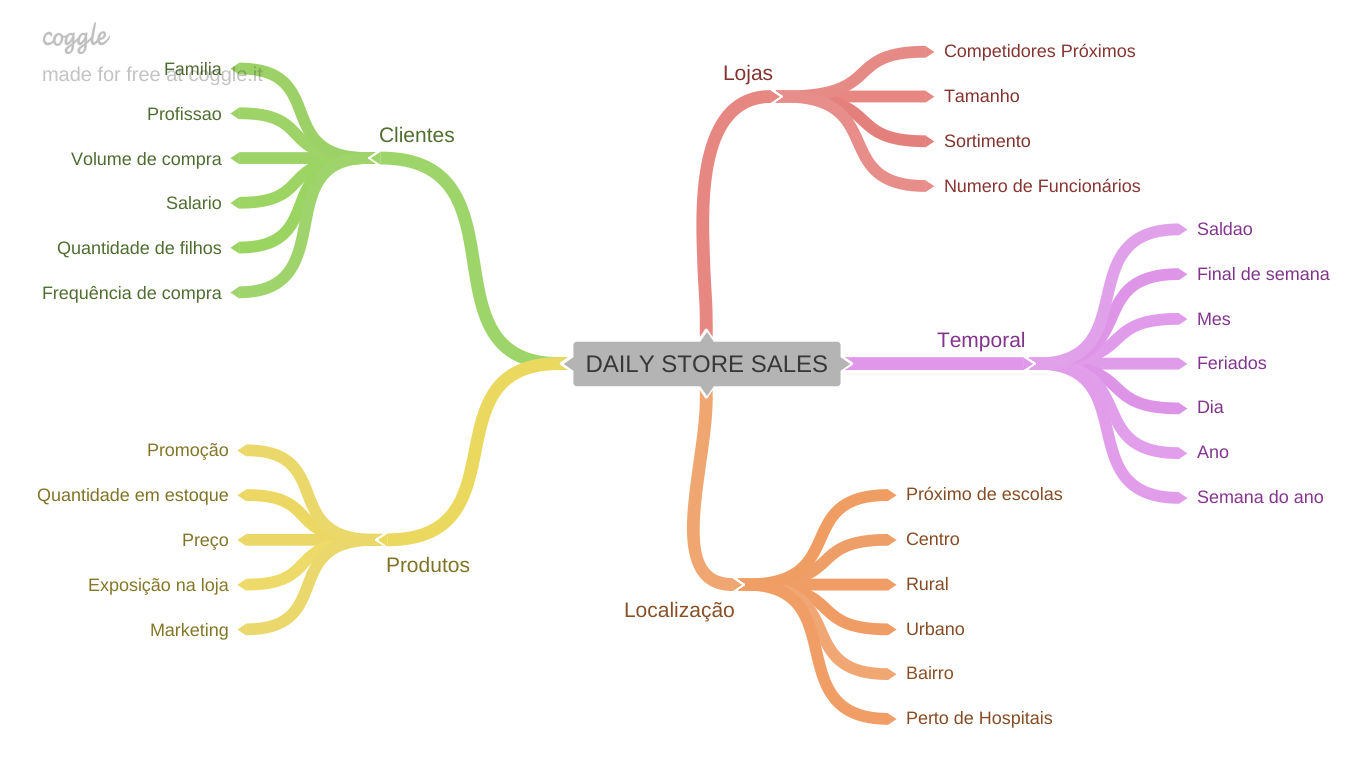

In [18]:
Image( 'img/mind_map.png')

 ### 2.1.1. Hipóteses Loja
 

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.


### 2.1.2. Hipóteses Produto


**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais promoções(maiores descontos) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

 ### 2.1.3. Hipóteses Tempo
 

**1.** Lojas abertas durante feriado de Natal vender mais.

**2.** Lojas deveriam vender mais ao longo do tempo.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final das Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante feriado de Natal vender mais.

**8.** Lojas deveriam vender mais ao longo do tempo.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3. Feature Engineering

In [14]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'] , month= x['competition_open_since_month'], day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )

df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) / 7).apply( lambda x: x.days ).astype( 'int64' )                 

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')               
                                            
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


C:\Users\samue\AppData\Local\Temp\ipykernel_8572\3202699970.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. STEP 03 - FILTERING VARIABLES


In [15]:
df3 = df2.copy()

## 3.1. Rows Filtering


In [16]:
df3 = df3[ (df3['open'] != 0) & (df3['sales'] > 0) ]

## 3.2. Columns Filtering


In [17]:
cols_drop = ['customers', 'open', 'month_map', 'promo_interval']
df3 = df3.drop( cols_drop, axis=1)

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [19]:
df4 = df3.copy()

## 4.1. Univariate Analysis


### 4.1.1. Response Variable


C:\Users\samue\AppData\Local\Temp\ipykernel_3680\1612213623.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['sales']);


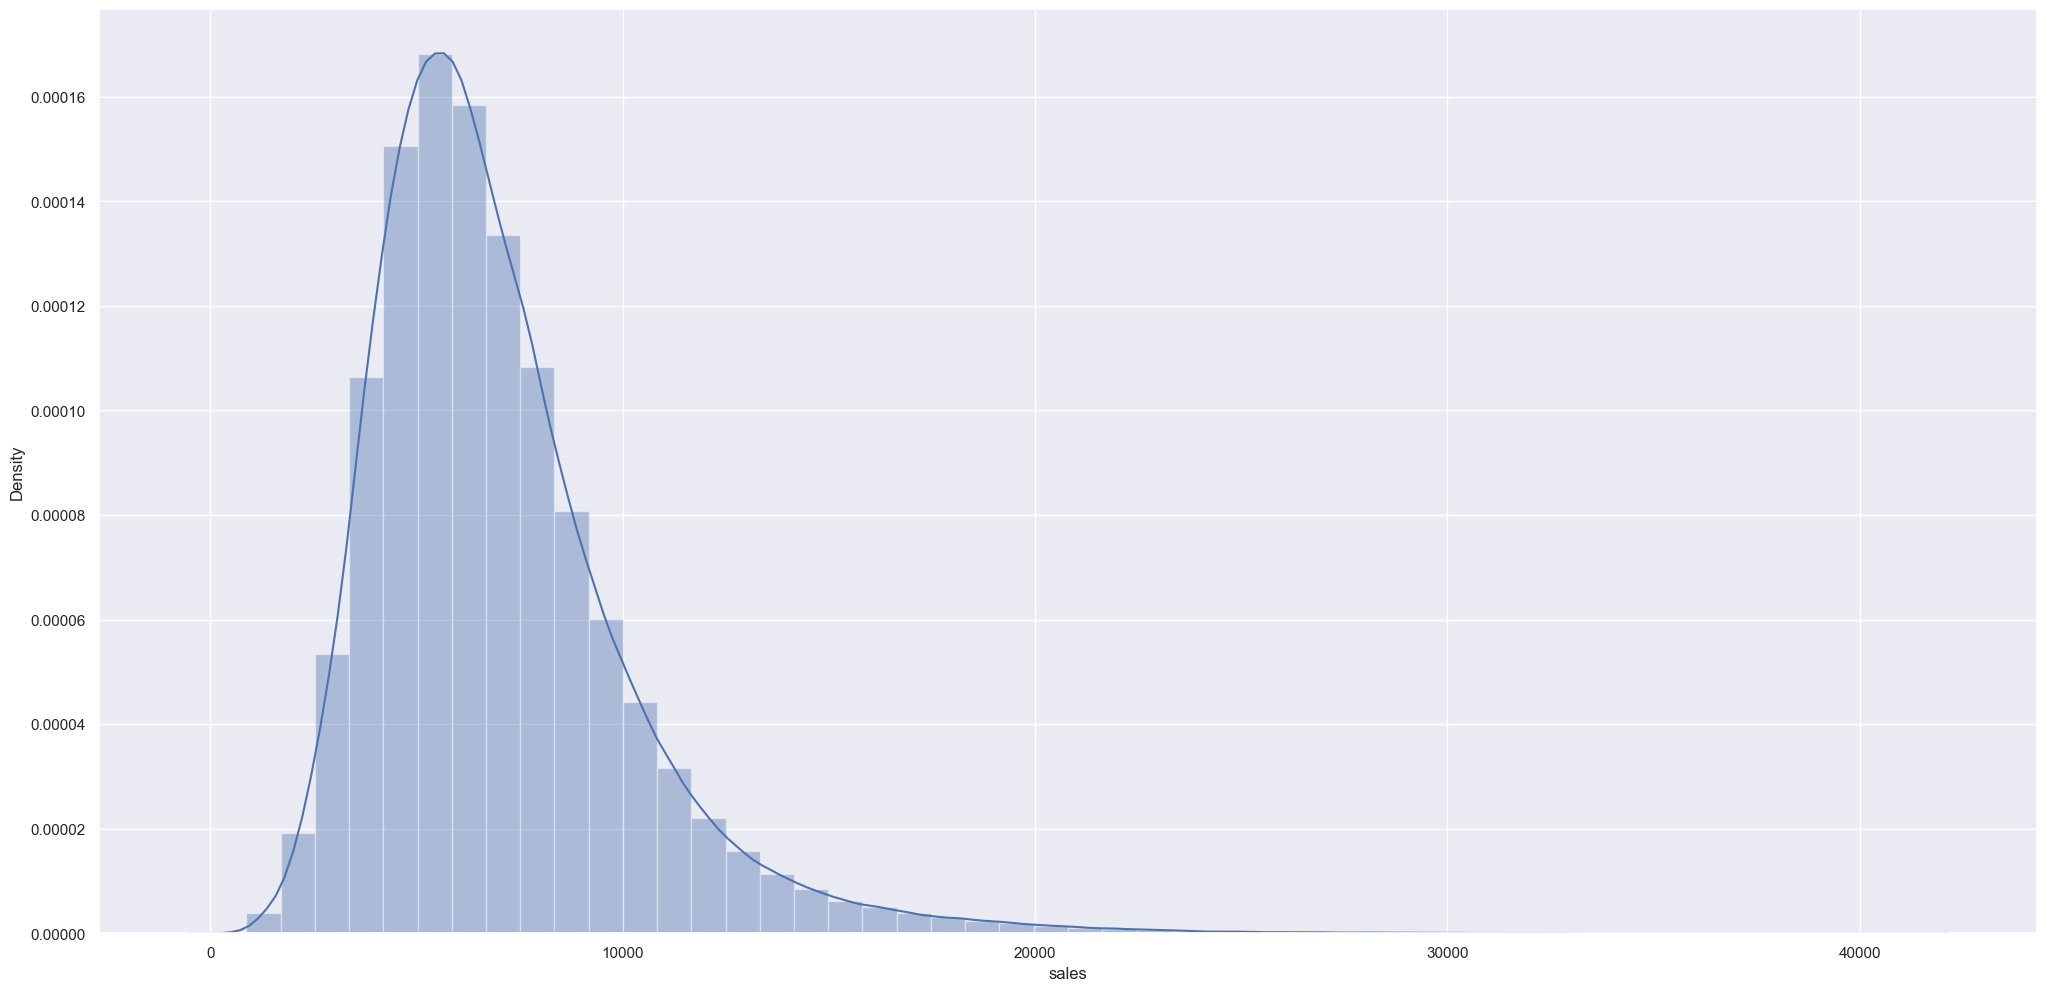

In [24]:
sns.distplot( df4['sales']);

### 4.1.2. Numerical Variable


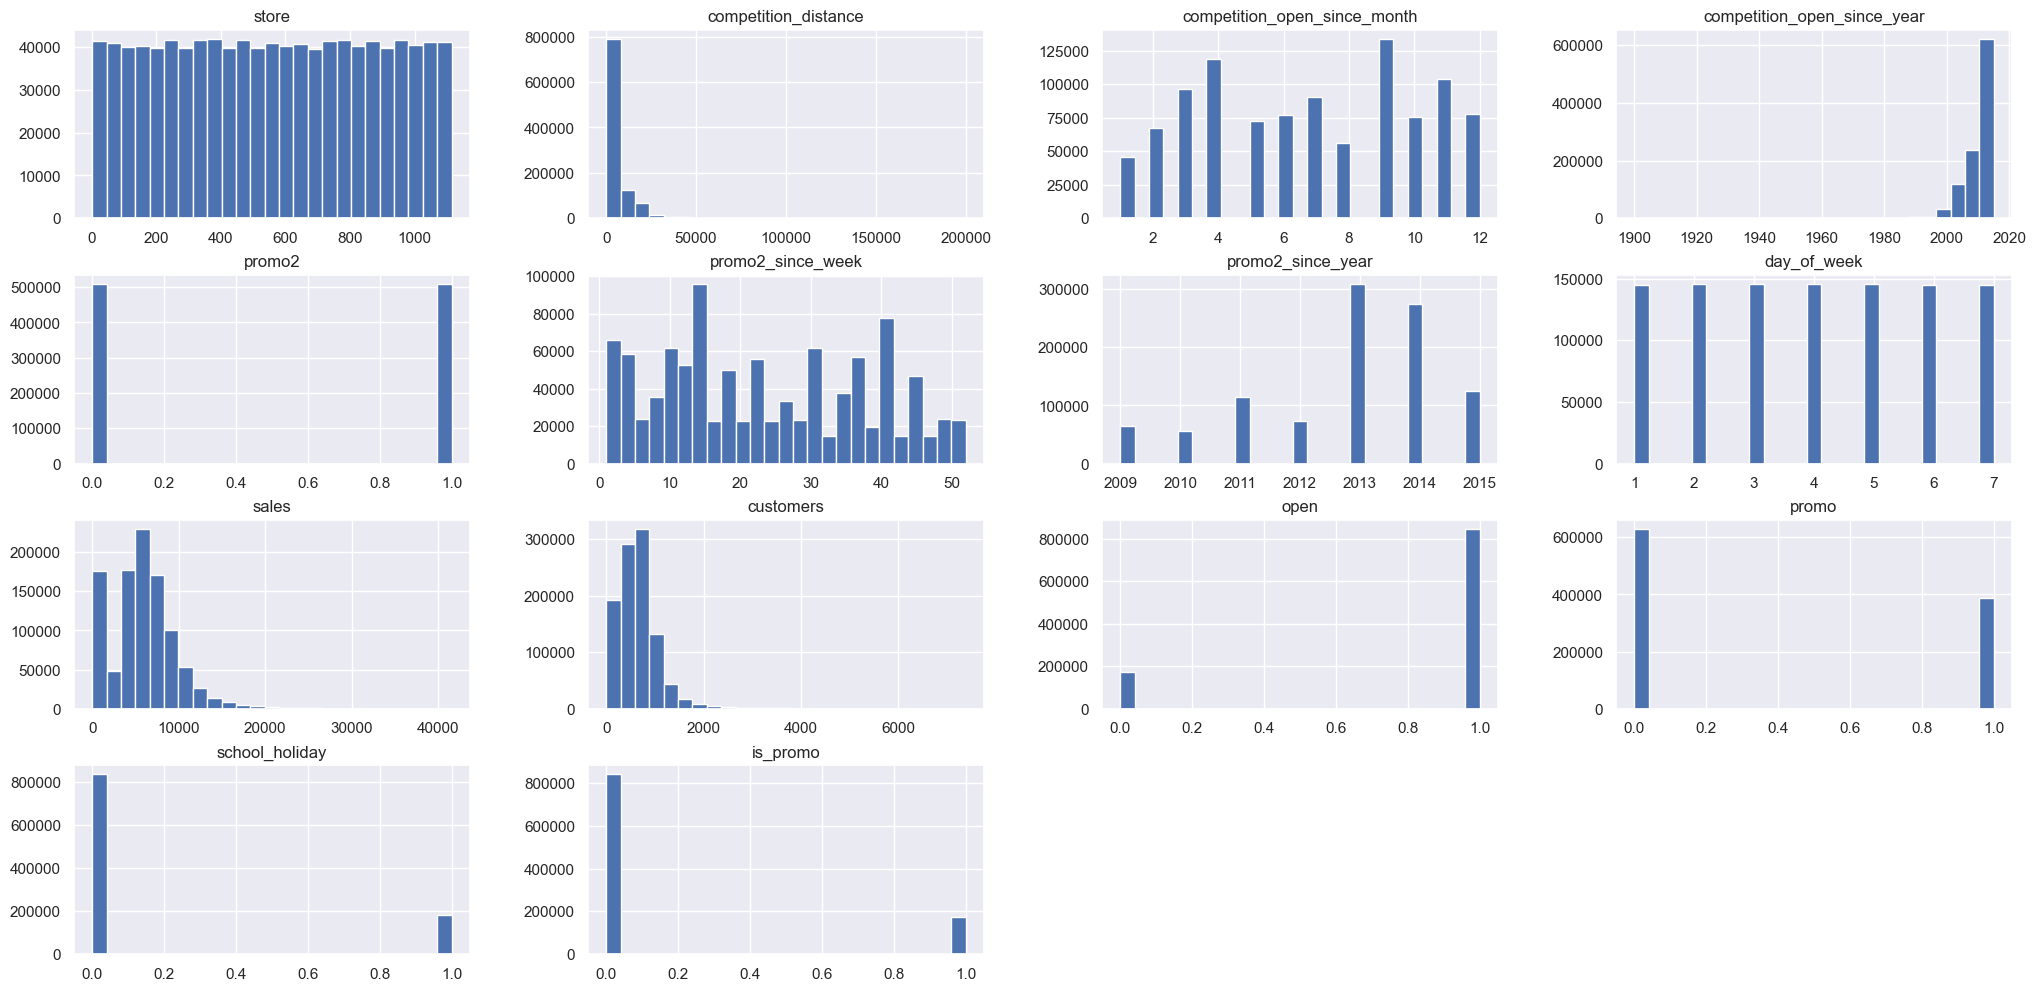

In [25]:
num_attributes.hist( bins=25 );

### 4.1.3. Categorical Variable



In [26]:
df3['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

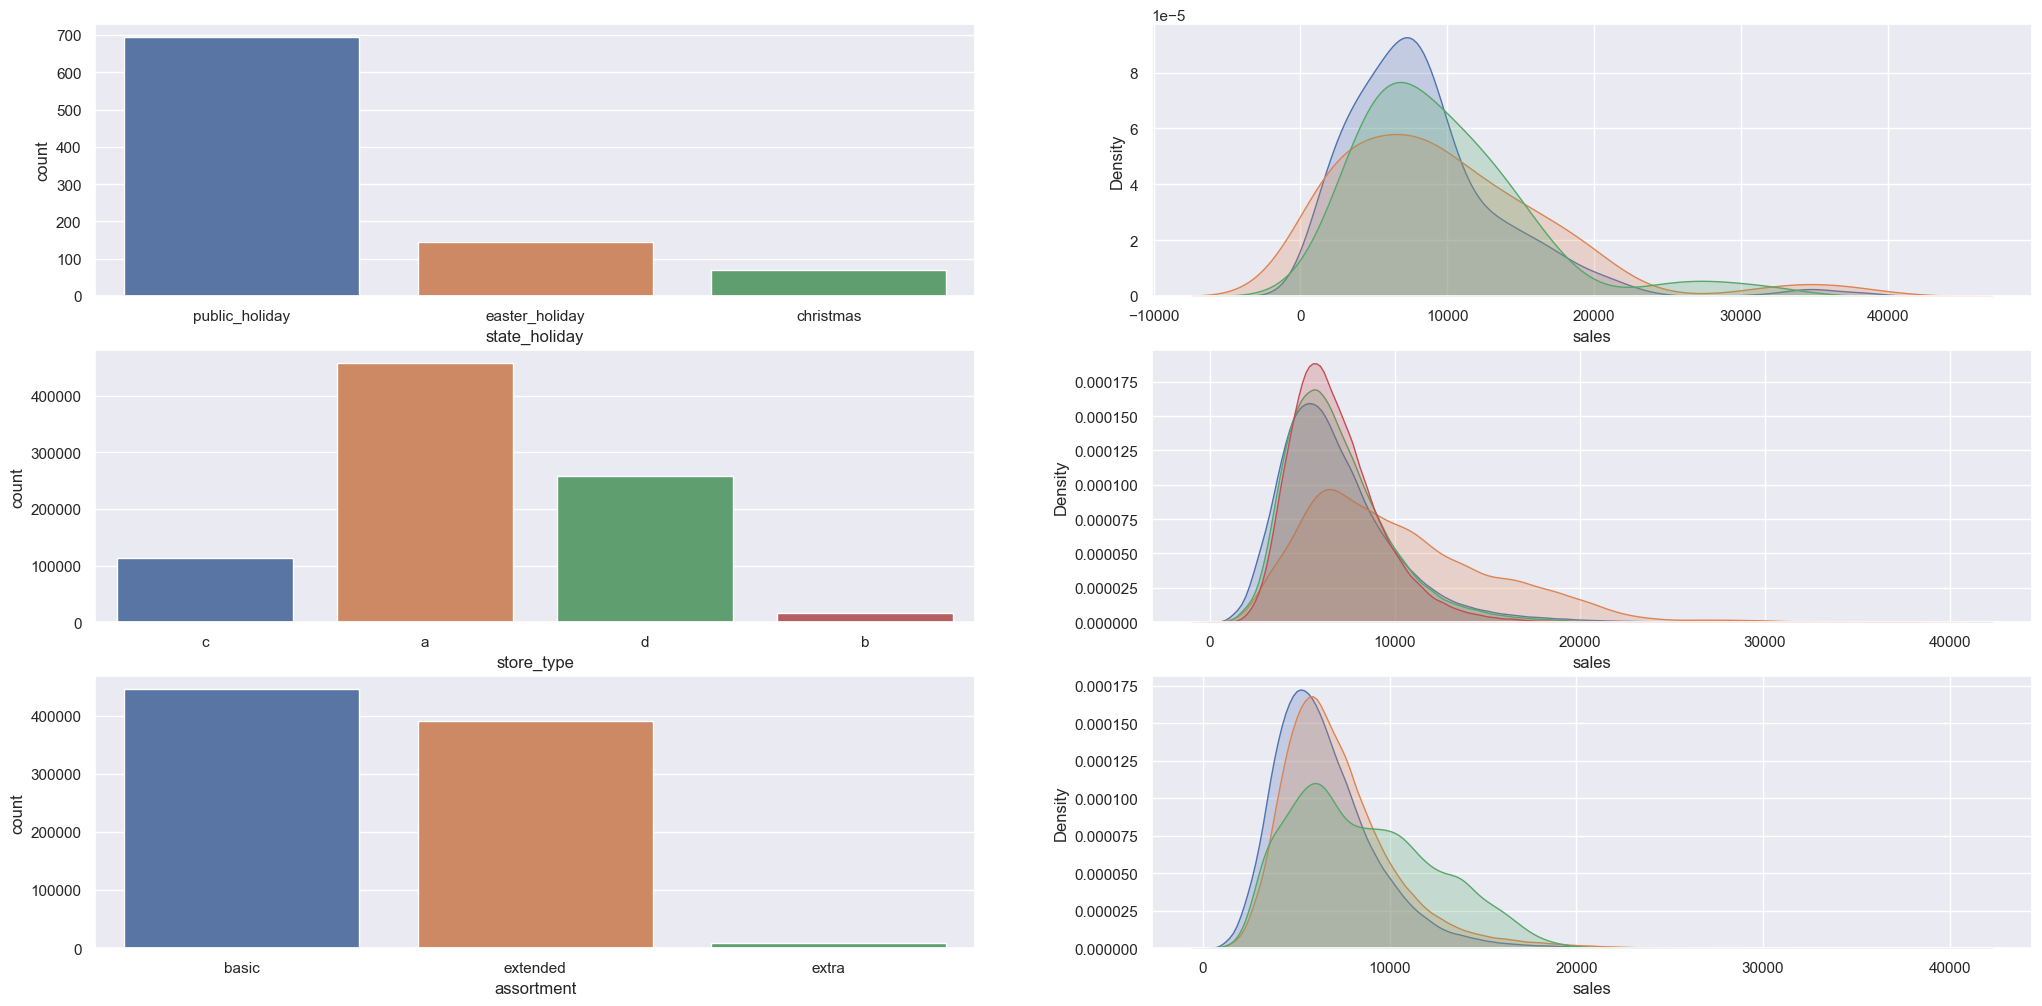

In [27]:
# state_holiday
plt.subplot( 3, 2, 1)
aux = df4[ df4['state_holiday'] != 'regular_day']
sns.countplot( x= aux['state_holiday']);

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['sales'], fill=True );
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['sales'], fill=True );
sns.kdeplot( df4[ df4['state_holiday'] == 'christmas']['sales'], fill=True );
# sns.kdeplot( data= aux , x= 'sales', hue = 'state_holiday', fill=True);

# store_type
plt.subplot( 3, 2, 3)
sns.countplot( x= df4['store_type']);

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], fill=True );
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], fill=True );
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], fill=True );
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], fill=True );

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( x= df4['assortment']);

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['sales'], fill=True );
sns.kdeplot( df4[ df4['assortment'] == 'extended']['sales'], fill=True );
sns.kdeplot( df4[ df4['assortment'] == 'extra']['sales'], fill=True );

## 4.2. Bivariate Analysis

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** - Lojas com maior sortimento VENDEM MENOS.


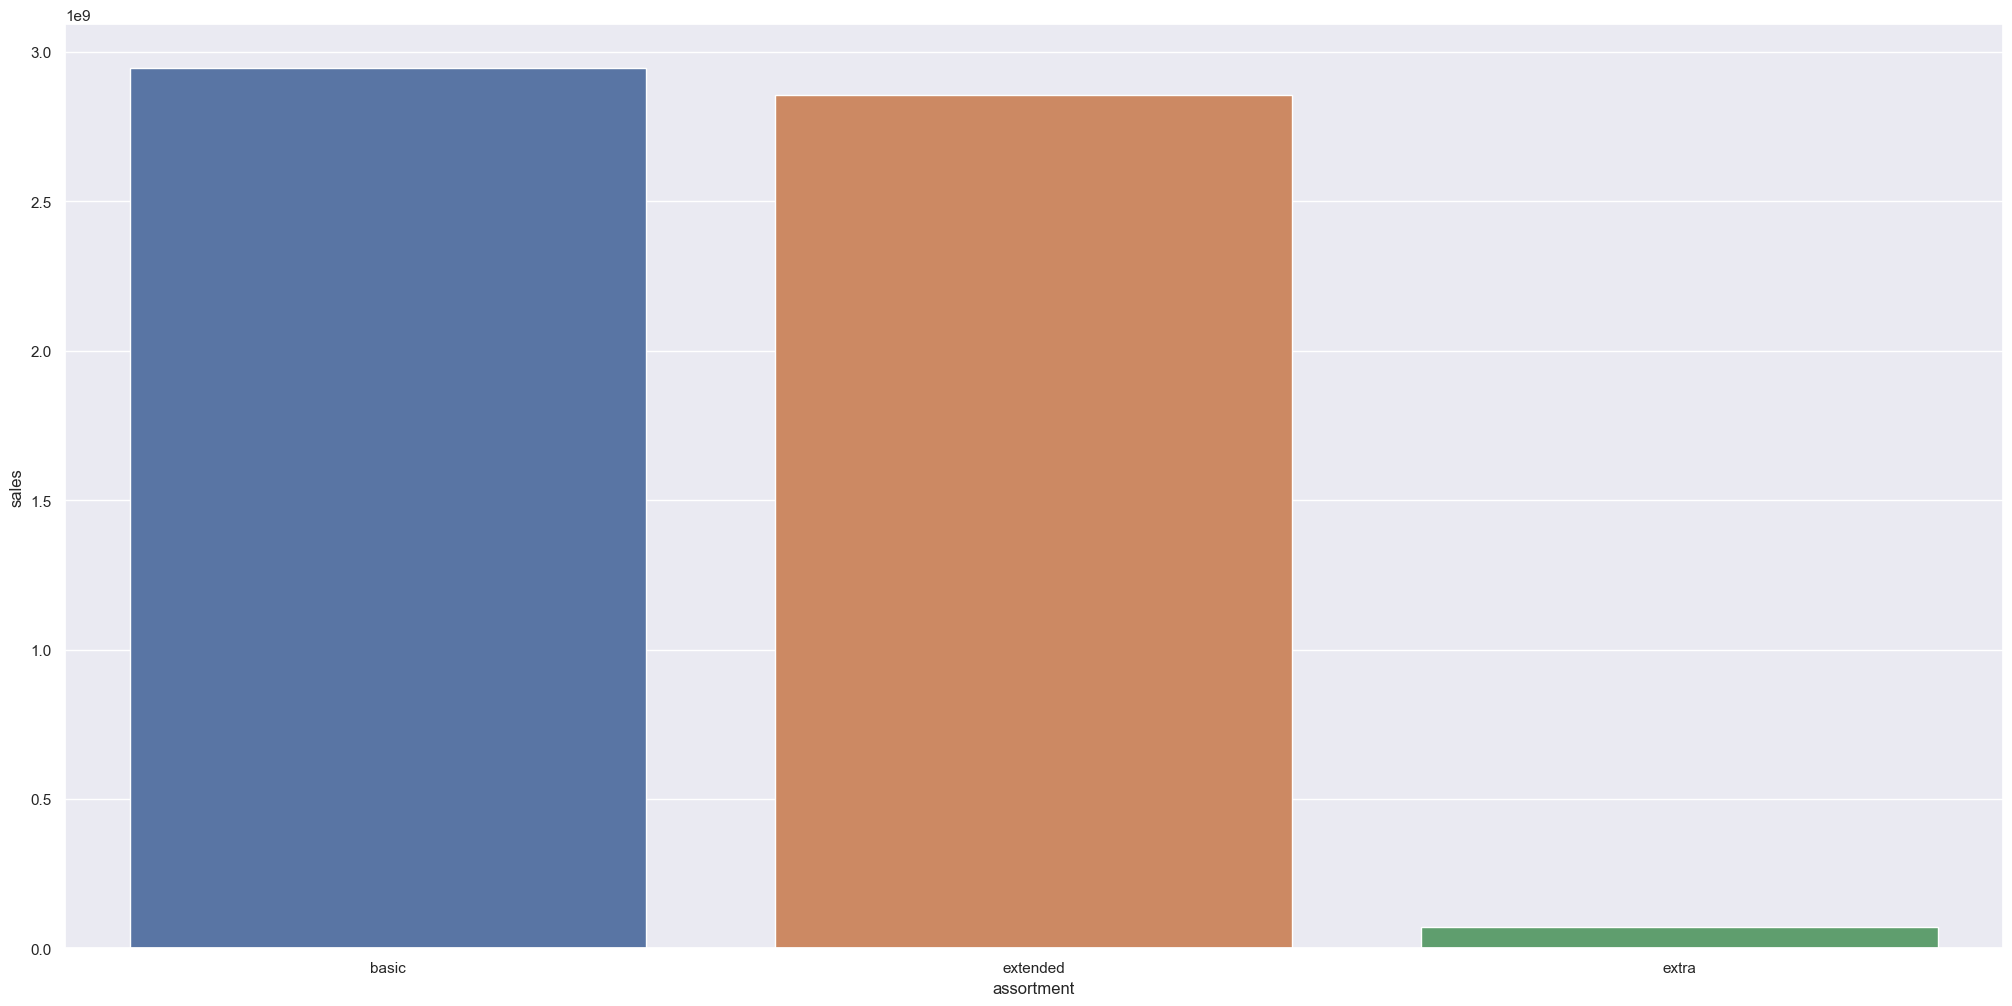

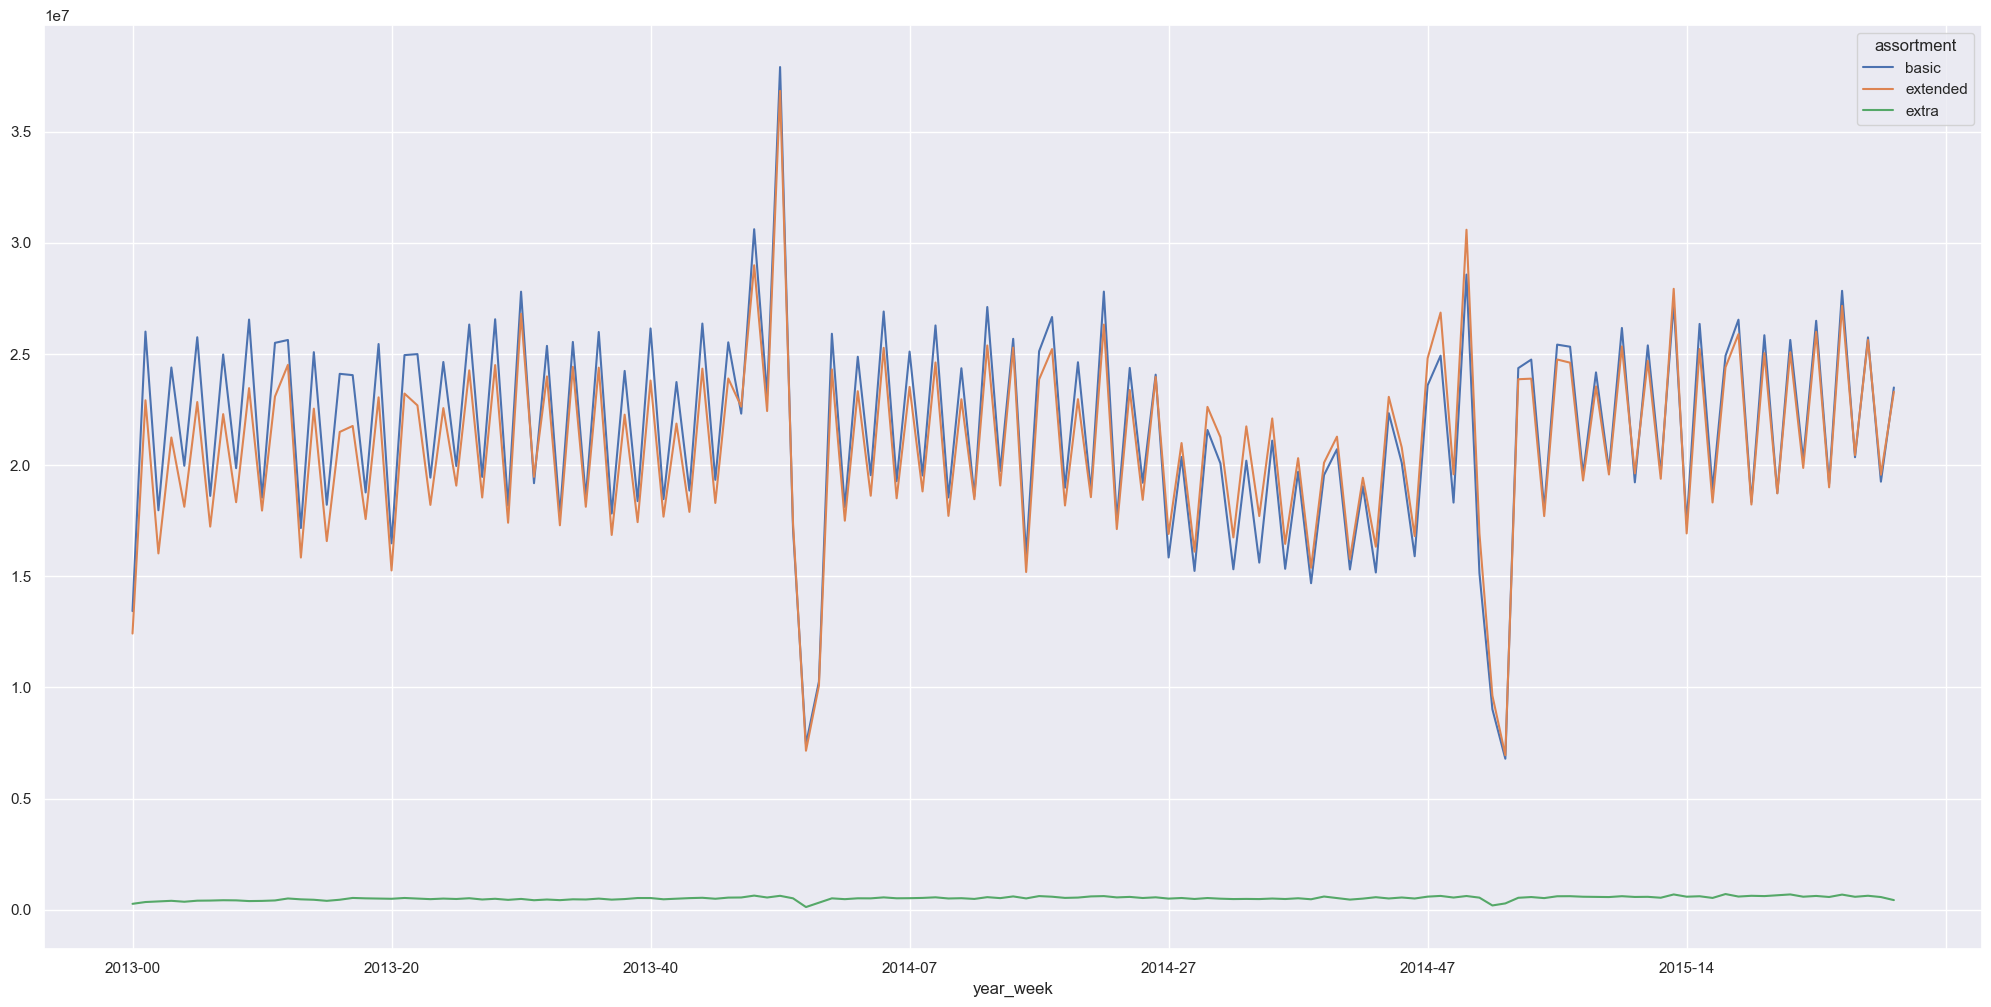

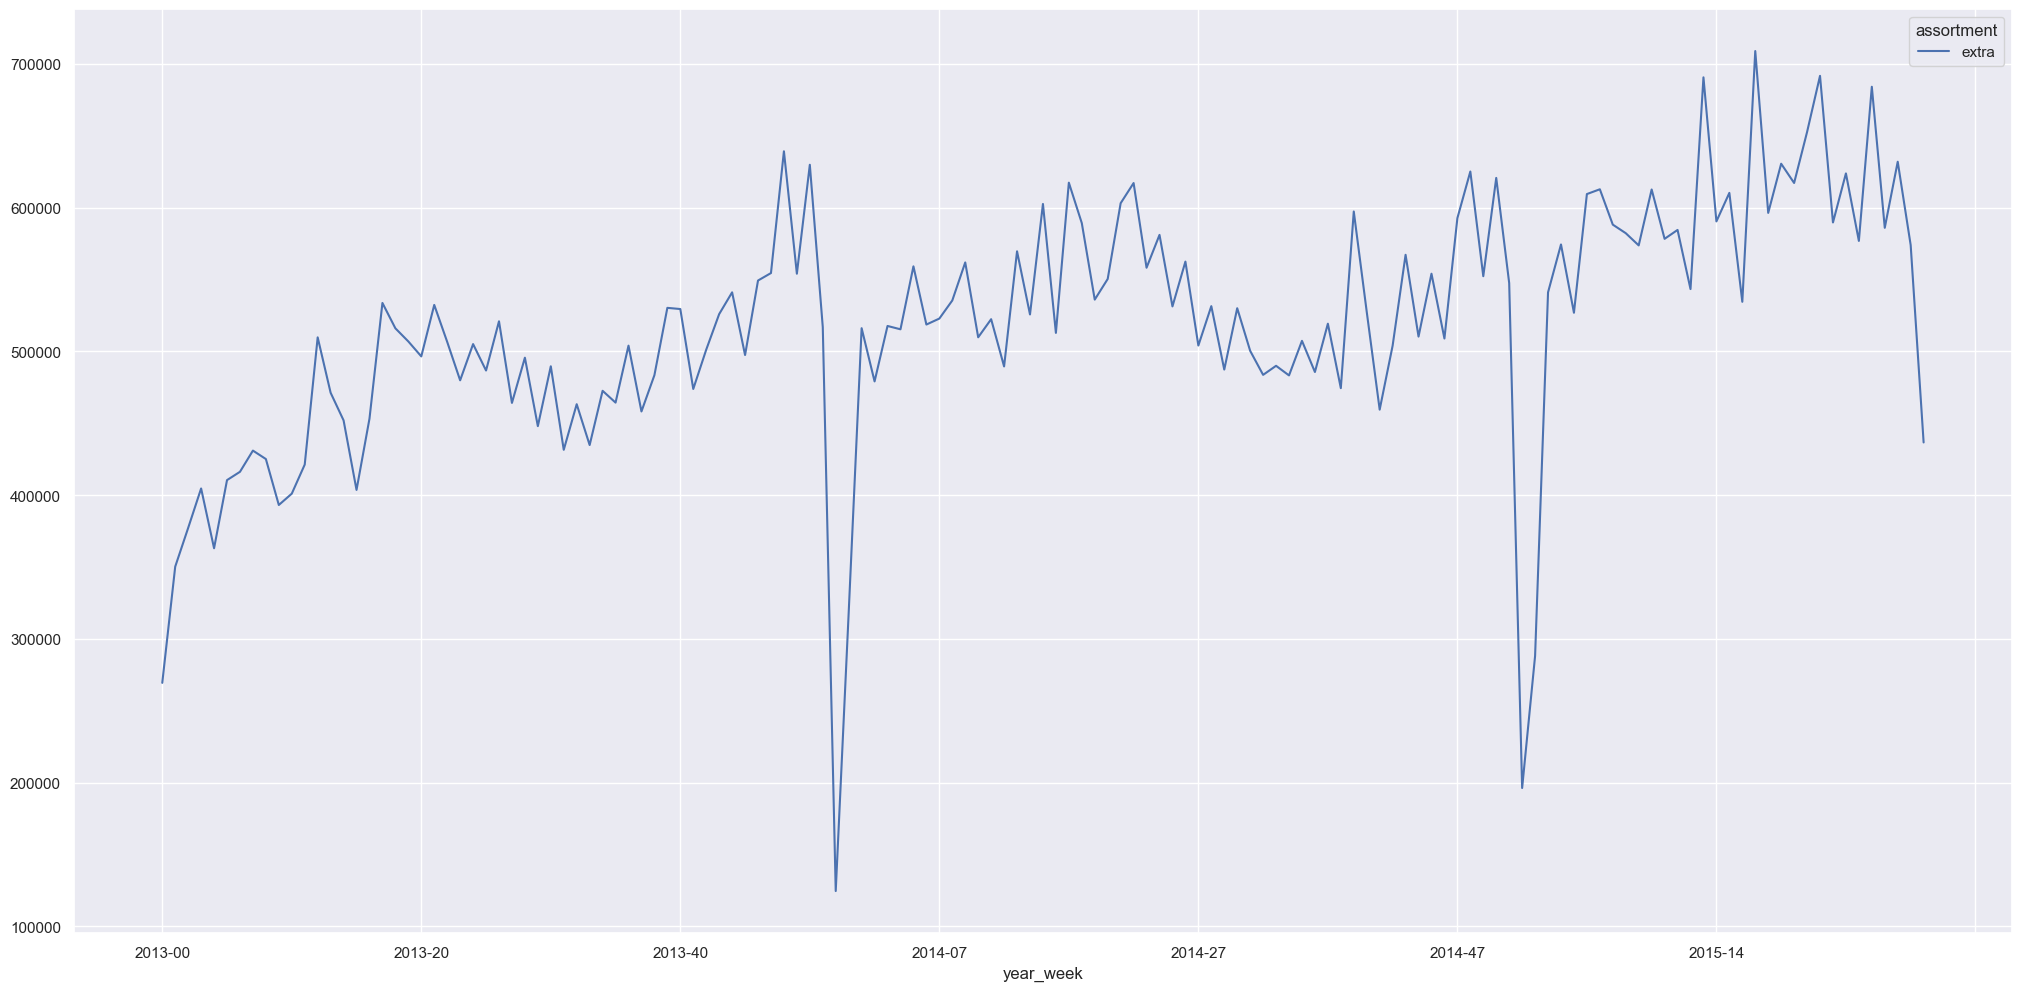

In [28]:
aux = df4[[ 'assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( data = aux, x='assortment', y='sales');

aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux1.pivot( index='year_week', columns='assortment' , values='sales' ).plot();


aux2 = aux1[ aux1['assortment'] == 'extra']
aux2.pivot( index='year_week', columns='assortment' , values='sales' ).plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** - Lojas com competidores próximos VENDEM MAIS


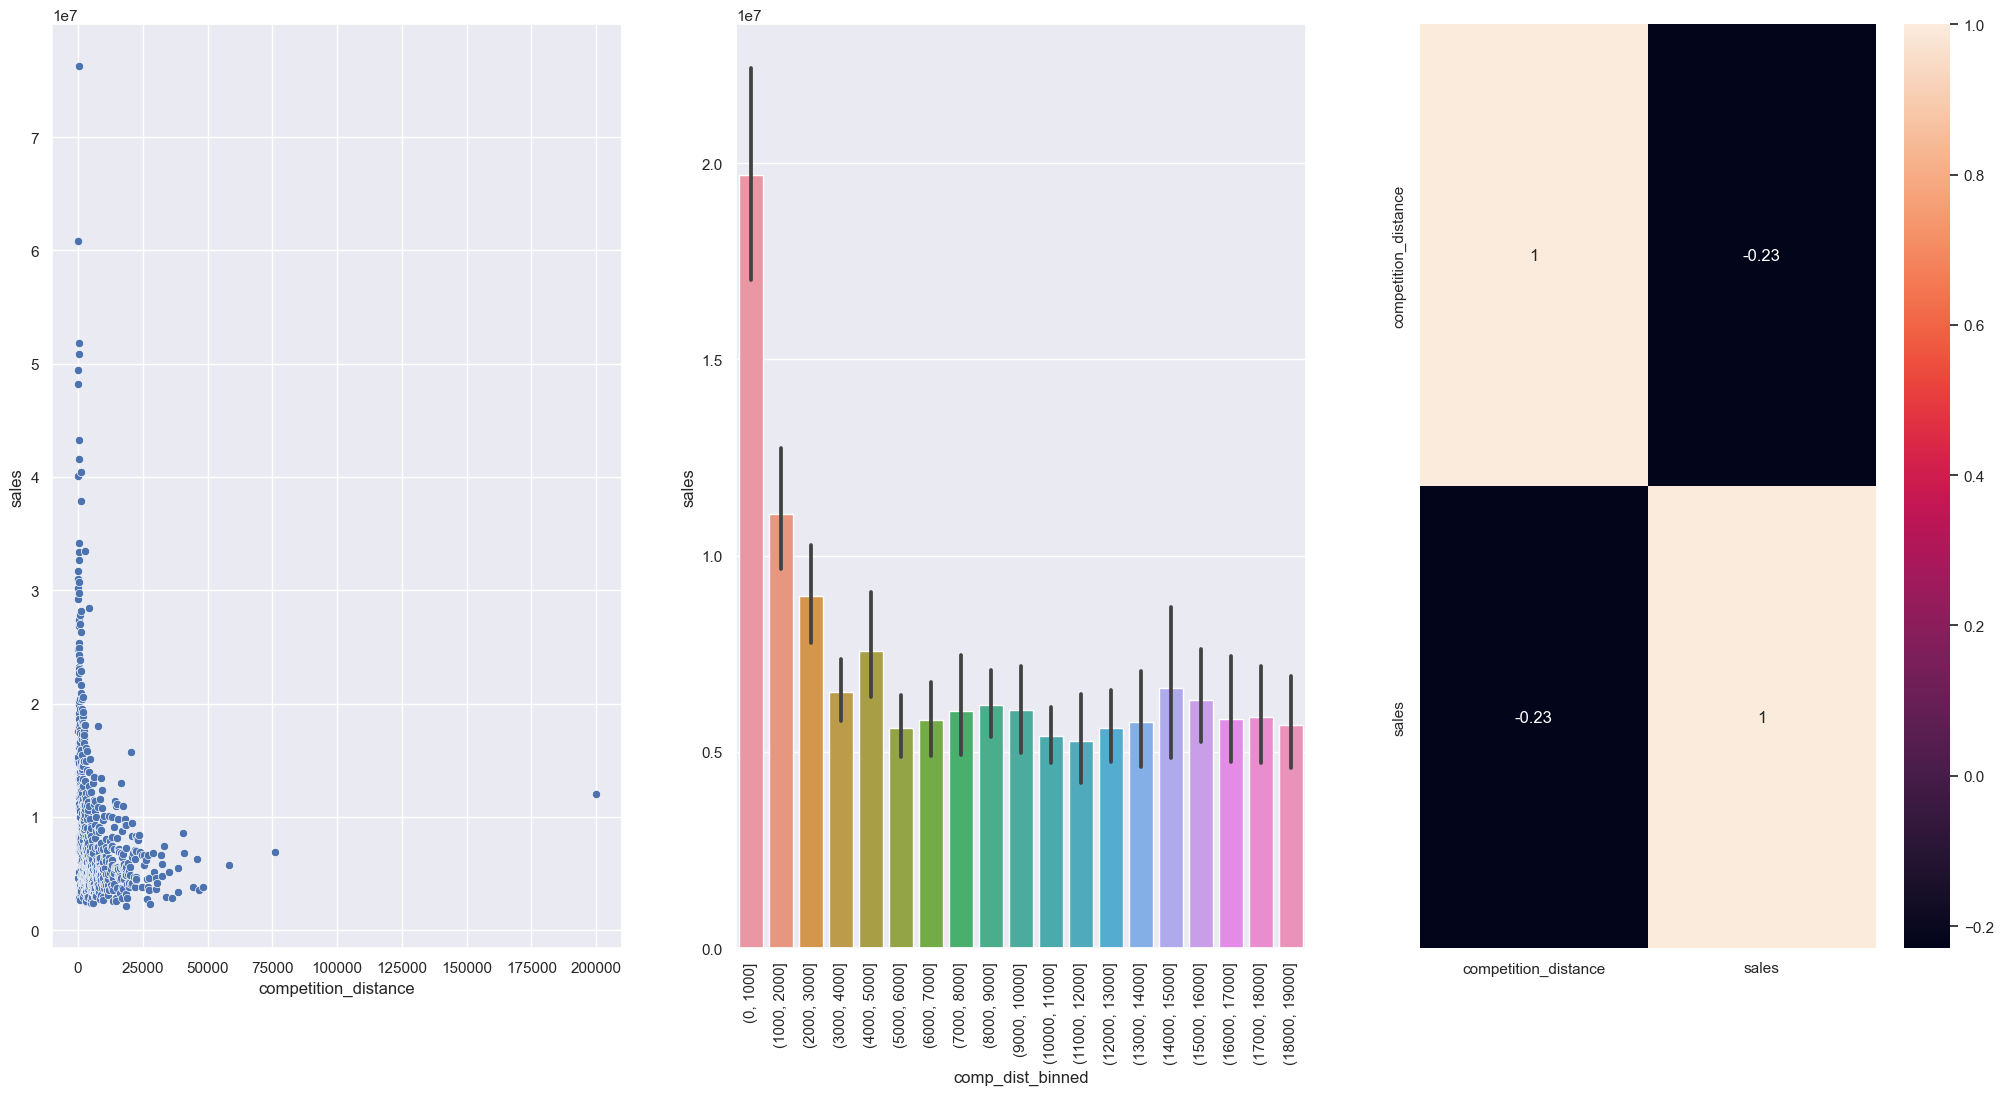

In [29]:
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1,3,1 )
sns.scatterplot( data= aux, x='competition_distance', y='sales');

plt.subplot( 1,3,2 )
bins = list( np.arange(0, 20000, 1000))
aux['comp_dist_binned'] = pd.cut( aux['competition_distance'], bins= bins)
aux1 = aux[['comp_dist_binned', 'sales']].groupby('comp_dist_binned').sum().reset_index()
sns.barplot( data= aux, x='comp_dist_binned', y='sales');
plt.xticks( rotation=90 )

plt.subplot( 1,3,3 )
sns.heatmap( aux.corr( method= 'pearson'), annot=True );

### H3. Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** - Lojas com competidores a mais tempo VENDEM MENOS


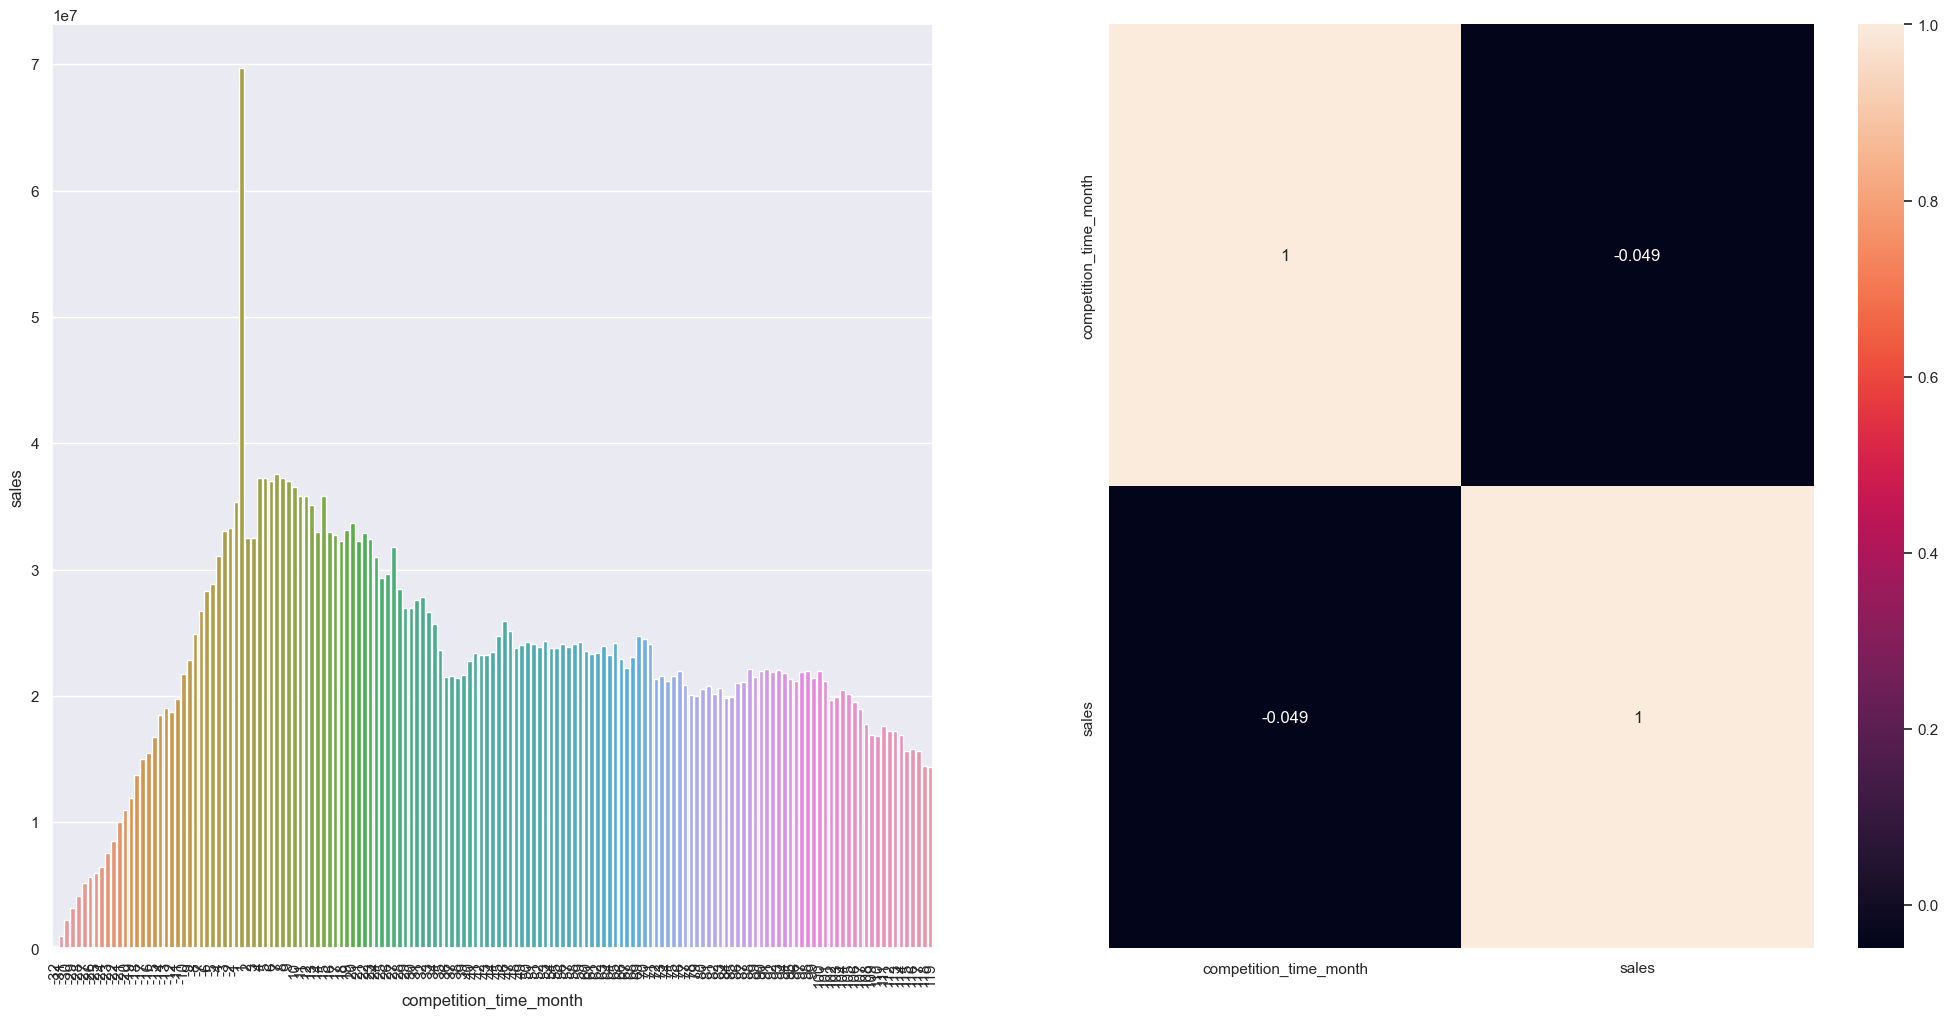

In [30]:
aux= df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux1 = aux[ (aux['competition_time_month'] < 120) & (aux['competition_time_month'] != 0)  ]

plt.subplot( 1, 2, 1)
sns.barplot( data=aux1, x='competition_time_month', y='sales');
plt.xticks( rotation=90 );

plt.subplot( 1, 2, 2)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** - Lojas com promoções ativas POR MAIS TEMPO tem VENDEM MENOS após um periodo da promoção

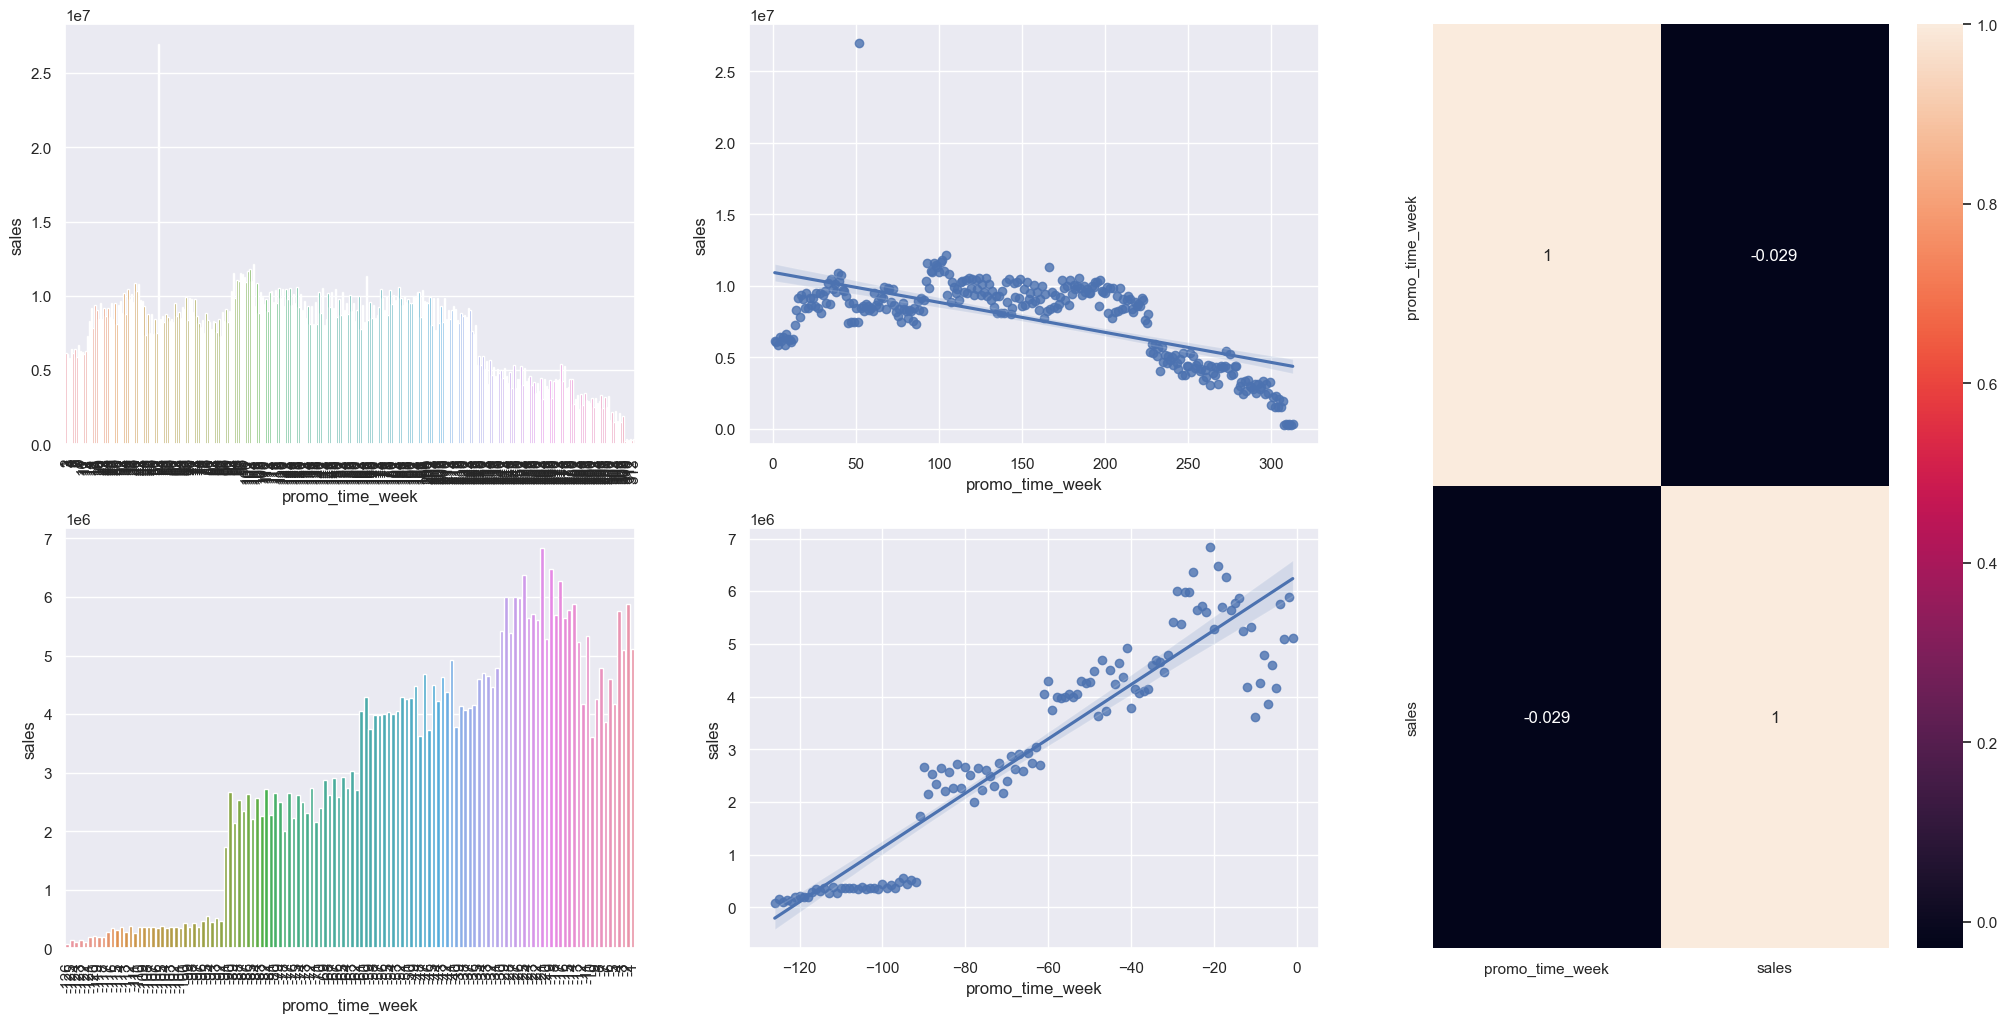

In [31]:
aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid= GridSpec( 2, 3)

plt.subplot( grid[0,0] )
aux1 = aux[ aux['promo_time_week'] > 0] # promo extendida
sns.barplot( data= aux1, x='promo_time_week', y='sales');
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( data= aux1, x='promo_time_week', y='sales');

plt.subplot( grid[1,0] )
aux2 = aux[ aux['promo_time_week'] < 0] # promo regular
sns.barplot( data=aux2, x='promo_time_week', y='sales');
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( data= aux2, x='promo_time_week', y='sales');

plt.subplot( grid[:, 2] )
sns.heatmap( aux.corr(method='pearson'), annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais. </s>


### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** - Lojas com mais promoções consecutivas vendem MENOS


In [32]:
aux = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values('sales', ascending=False).reset_index()
aux

,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


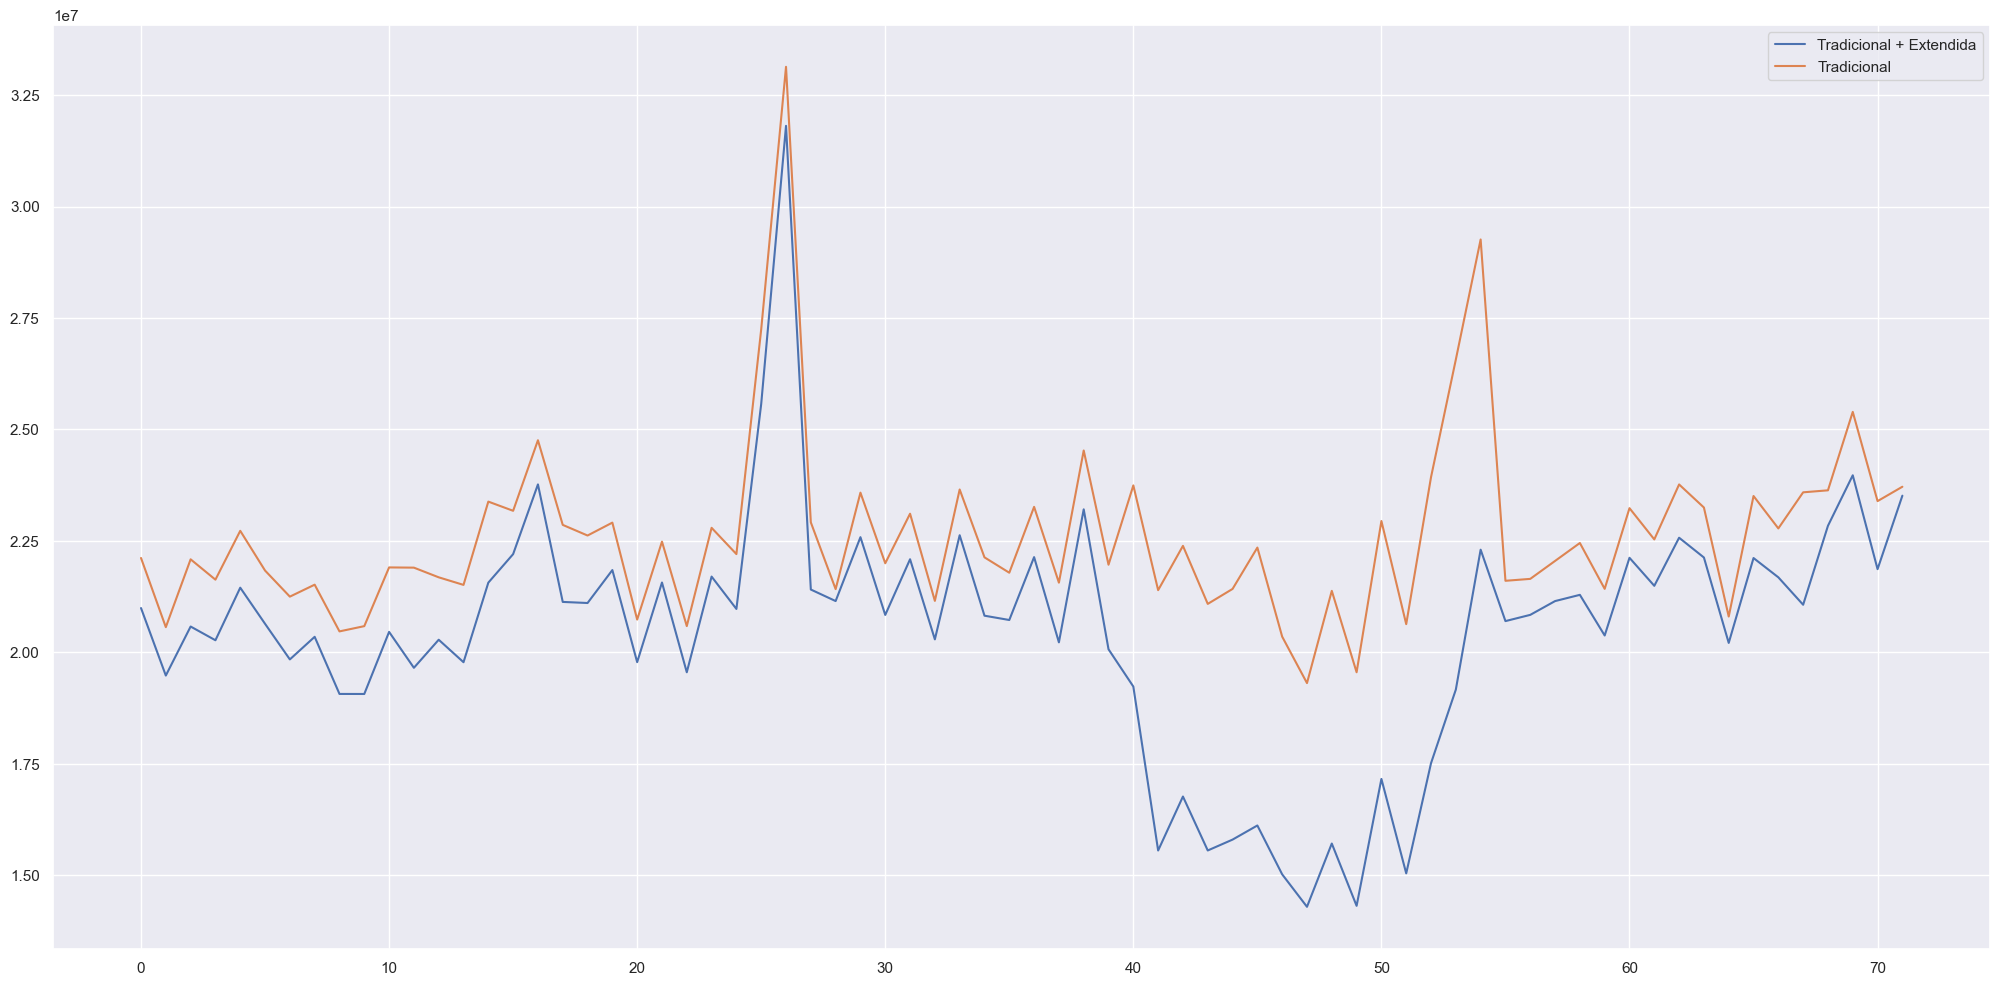

In [33]:
aux1 = df4[ ( df4['promo'] == 1 ) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[ ( df4['promo'] == 1 ) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend ( labels= ['Tradicional + Extendida', 'Tradicional'] );

### H7. Lojas abertas durante feriado de Natal vendem mais.
**FALSA** - Lojas abertas no Natal VENDEM MENOS

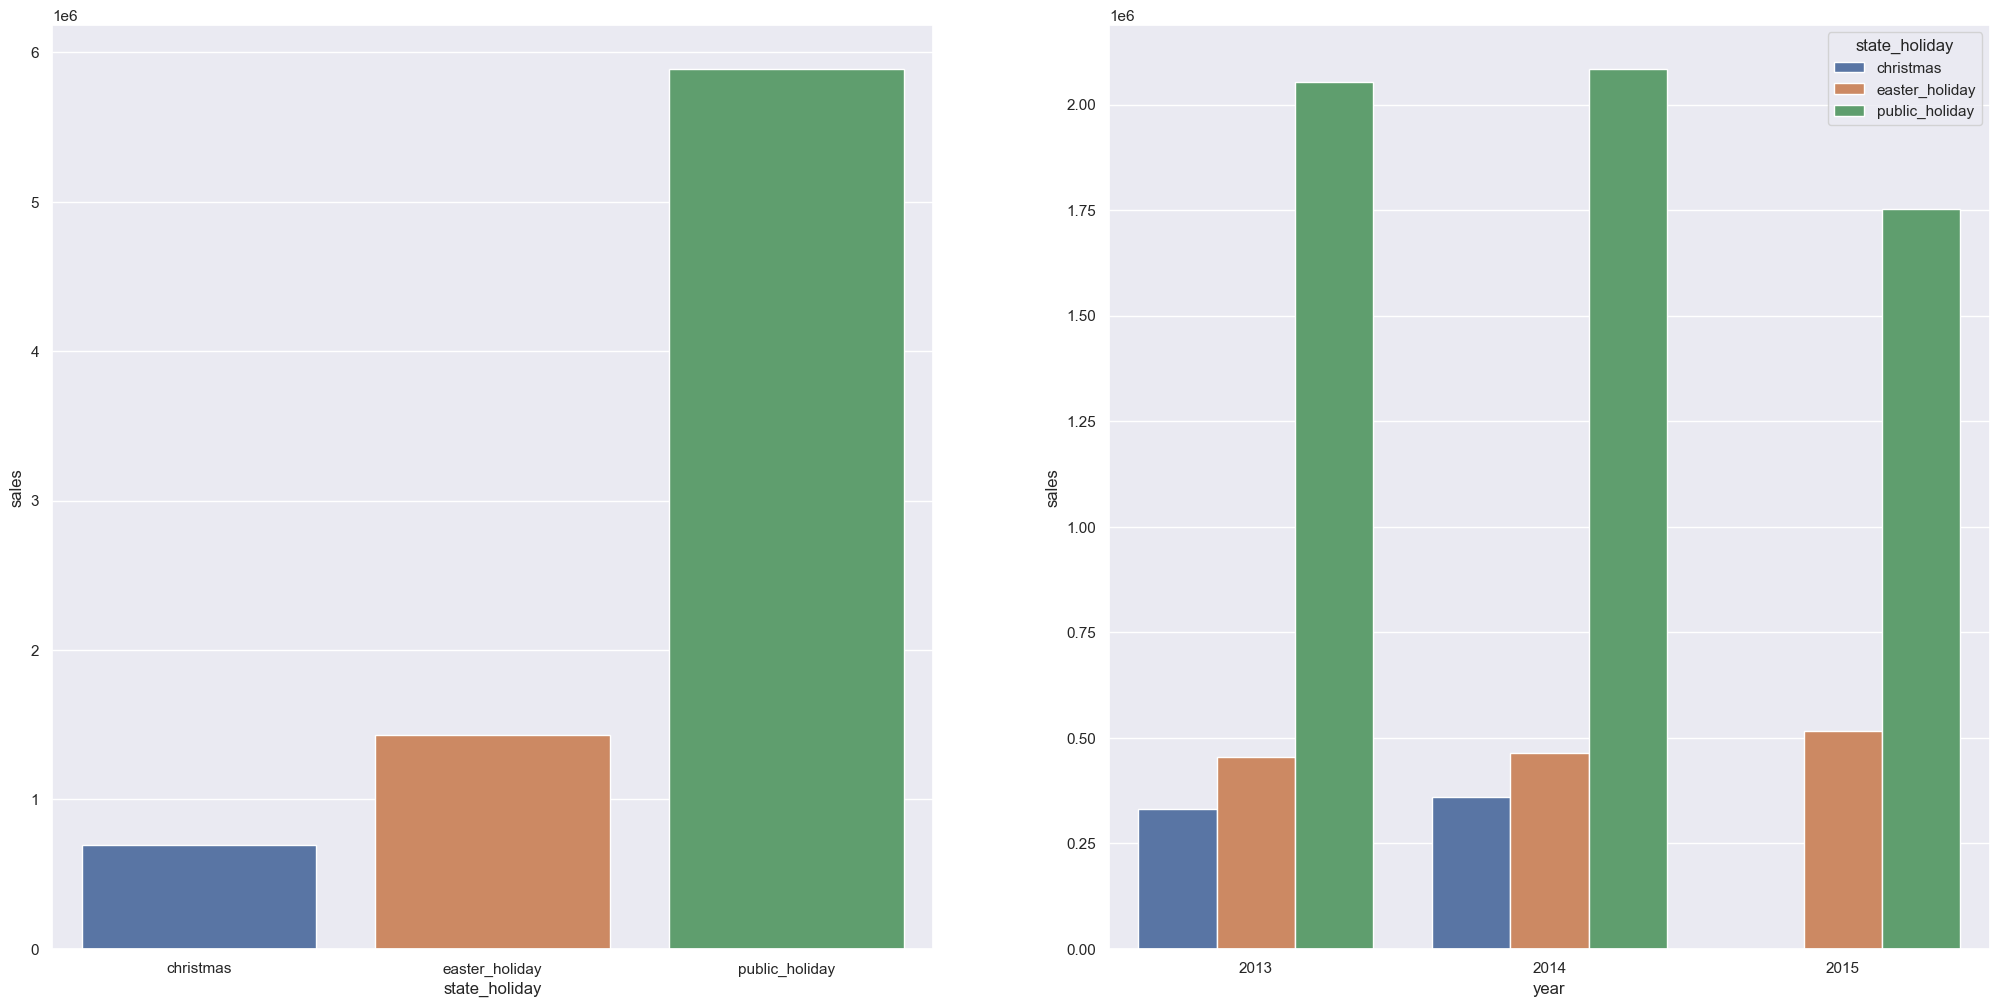

In [34]:
aux = df4[ df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1= aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( data= aux1, x='state_holiday', y='sales');


plt.subplot(1, 2, 2)
aux2= aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( data= aux2, x='year', hue='state_holiday', y='sales');

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** - Lojas vendem MENOS ao longo dos anos

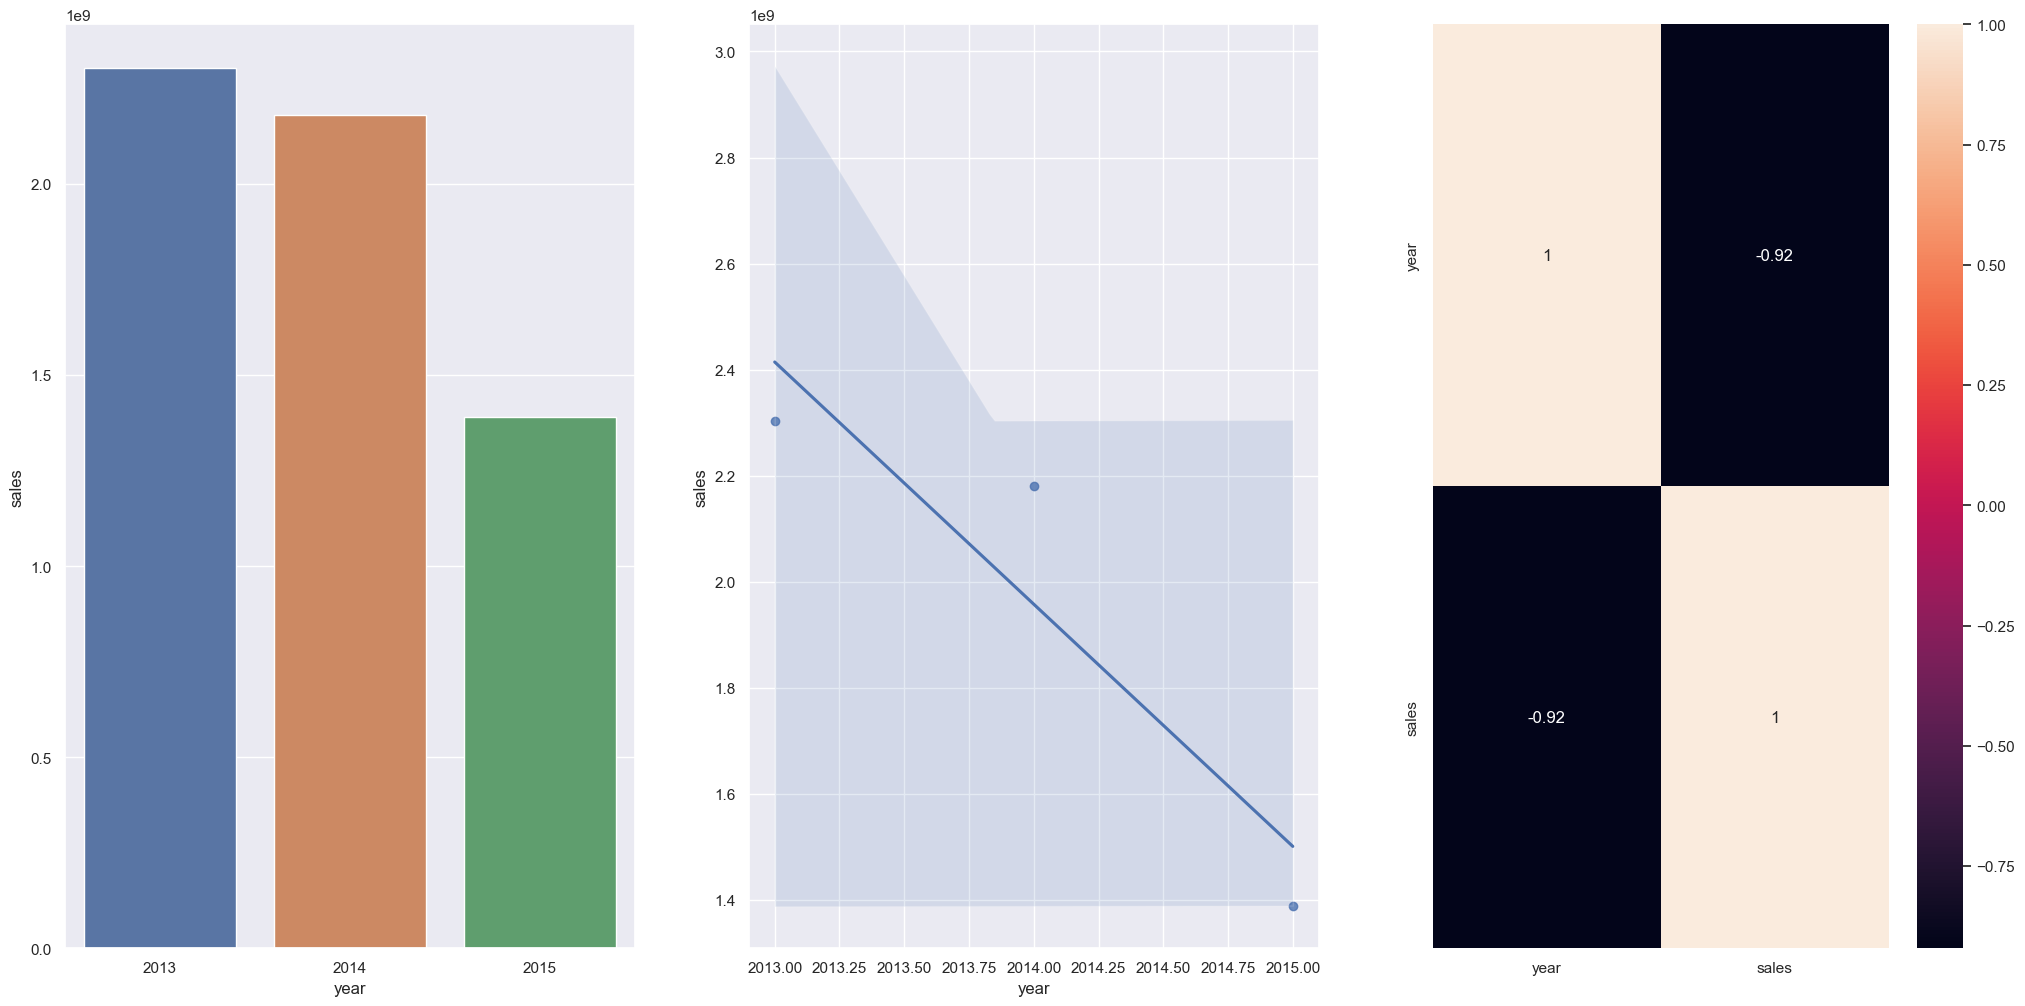

In [35]:
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( data=aux, x='year', y='sales');

plt.subplot(1, 3, 2)
sns.regplot( data=aux, x='year', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux.corr( method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA** - Lojas vendem MAIS no segundo semestre

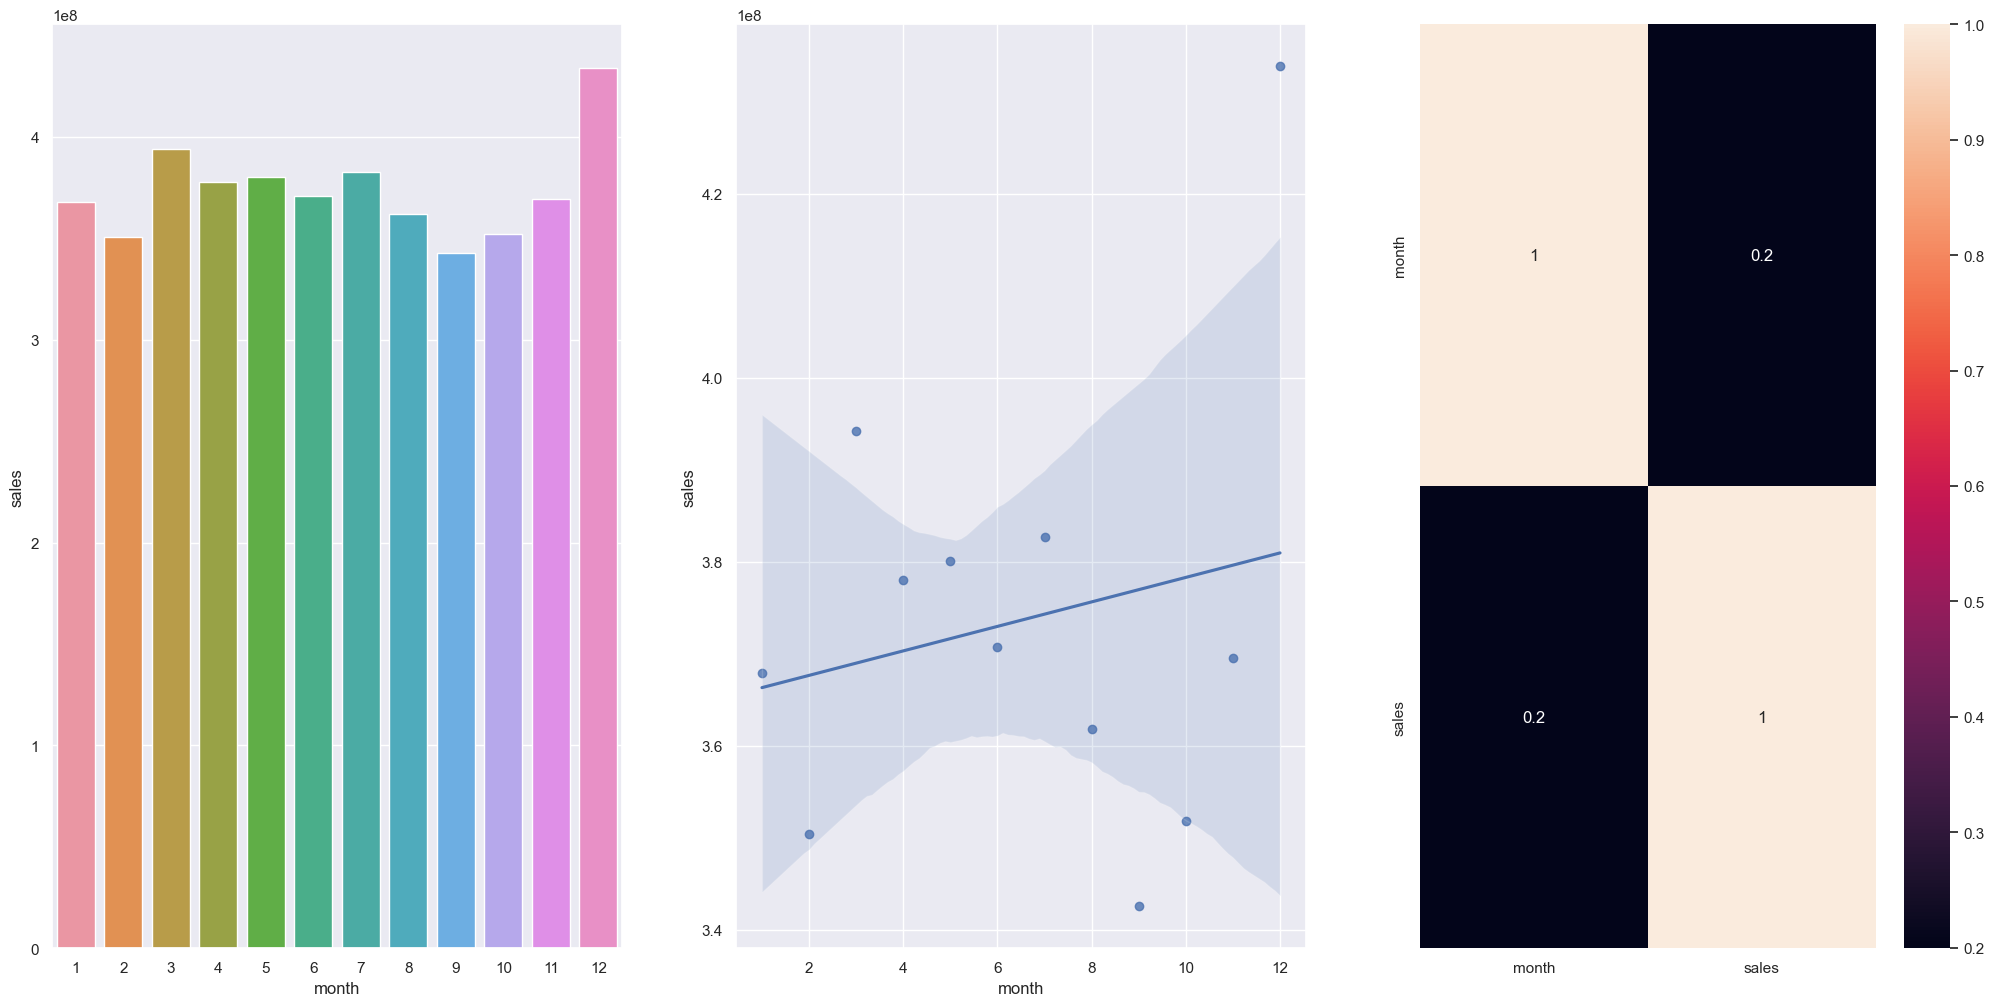

In [36]:
aux = df4[ df4['year'] < 2015]
aux = aux[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( data=aux, x='month', y='sales');

plt.subplot(1, 3, 2)
sns.regplot( data=aux, x='month', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux.corr( method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**FALSO** Lojas VENDEM MENOS após dia 10 de cada mês

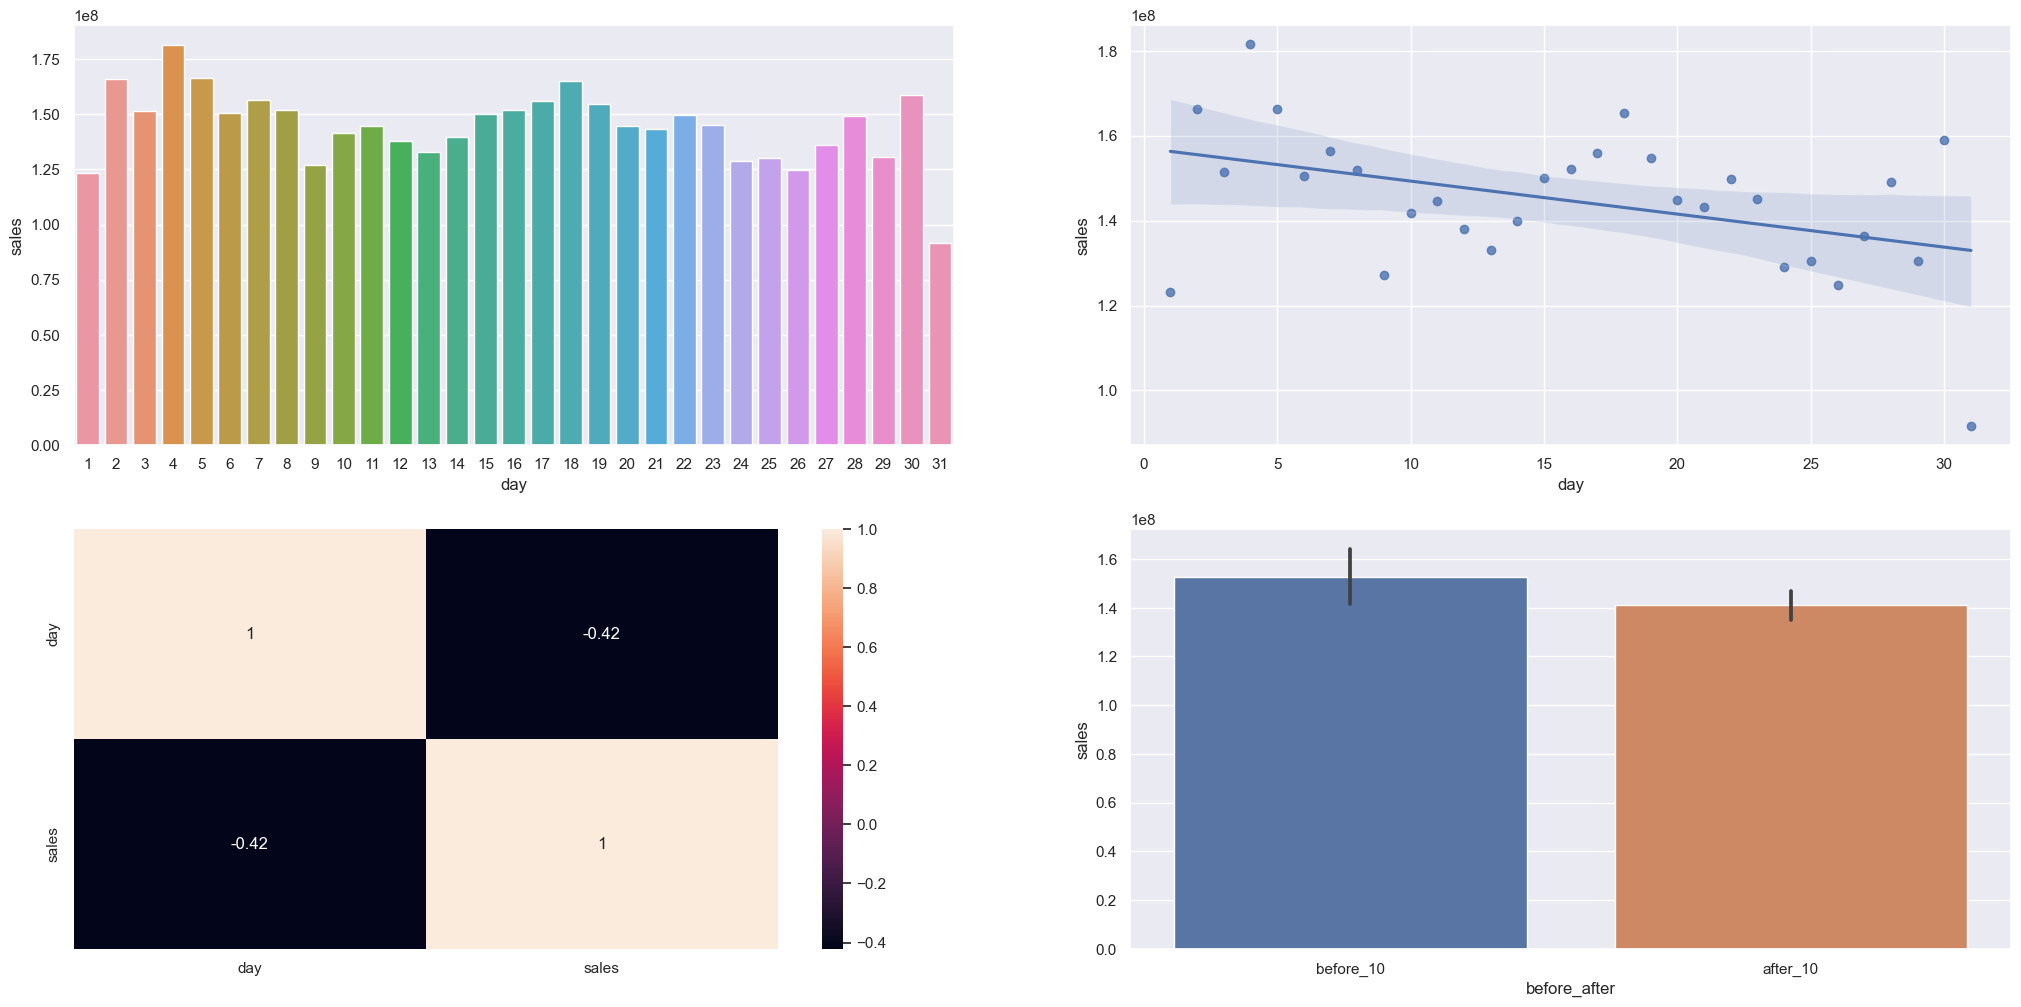

In [37]:
aux = df4[ df4['year'] < 2015]
aux = aux[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot( data=aux, x='day', y='sales');

plt.subplot(2, 2, 2)
sns.regplot( data=aux, x='day', y='sales');

plt.subplot(2, 2, 3)
sns.heatmap( aux.corr( method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux['before_after'] = aux['day'].apply( lambda x: 'before_10' if x < 10 else 'after_10')
sns.barplot( data=aux, x='before_after', y='sales');

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** - Lojas vendem MENOS aos finais de semana

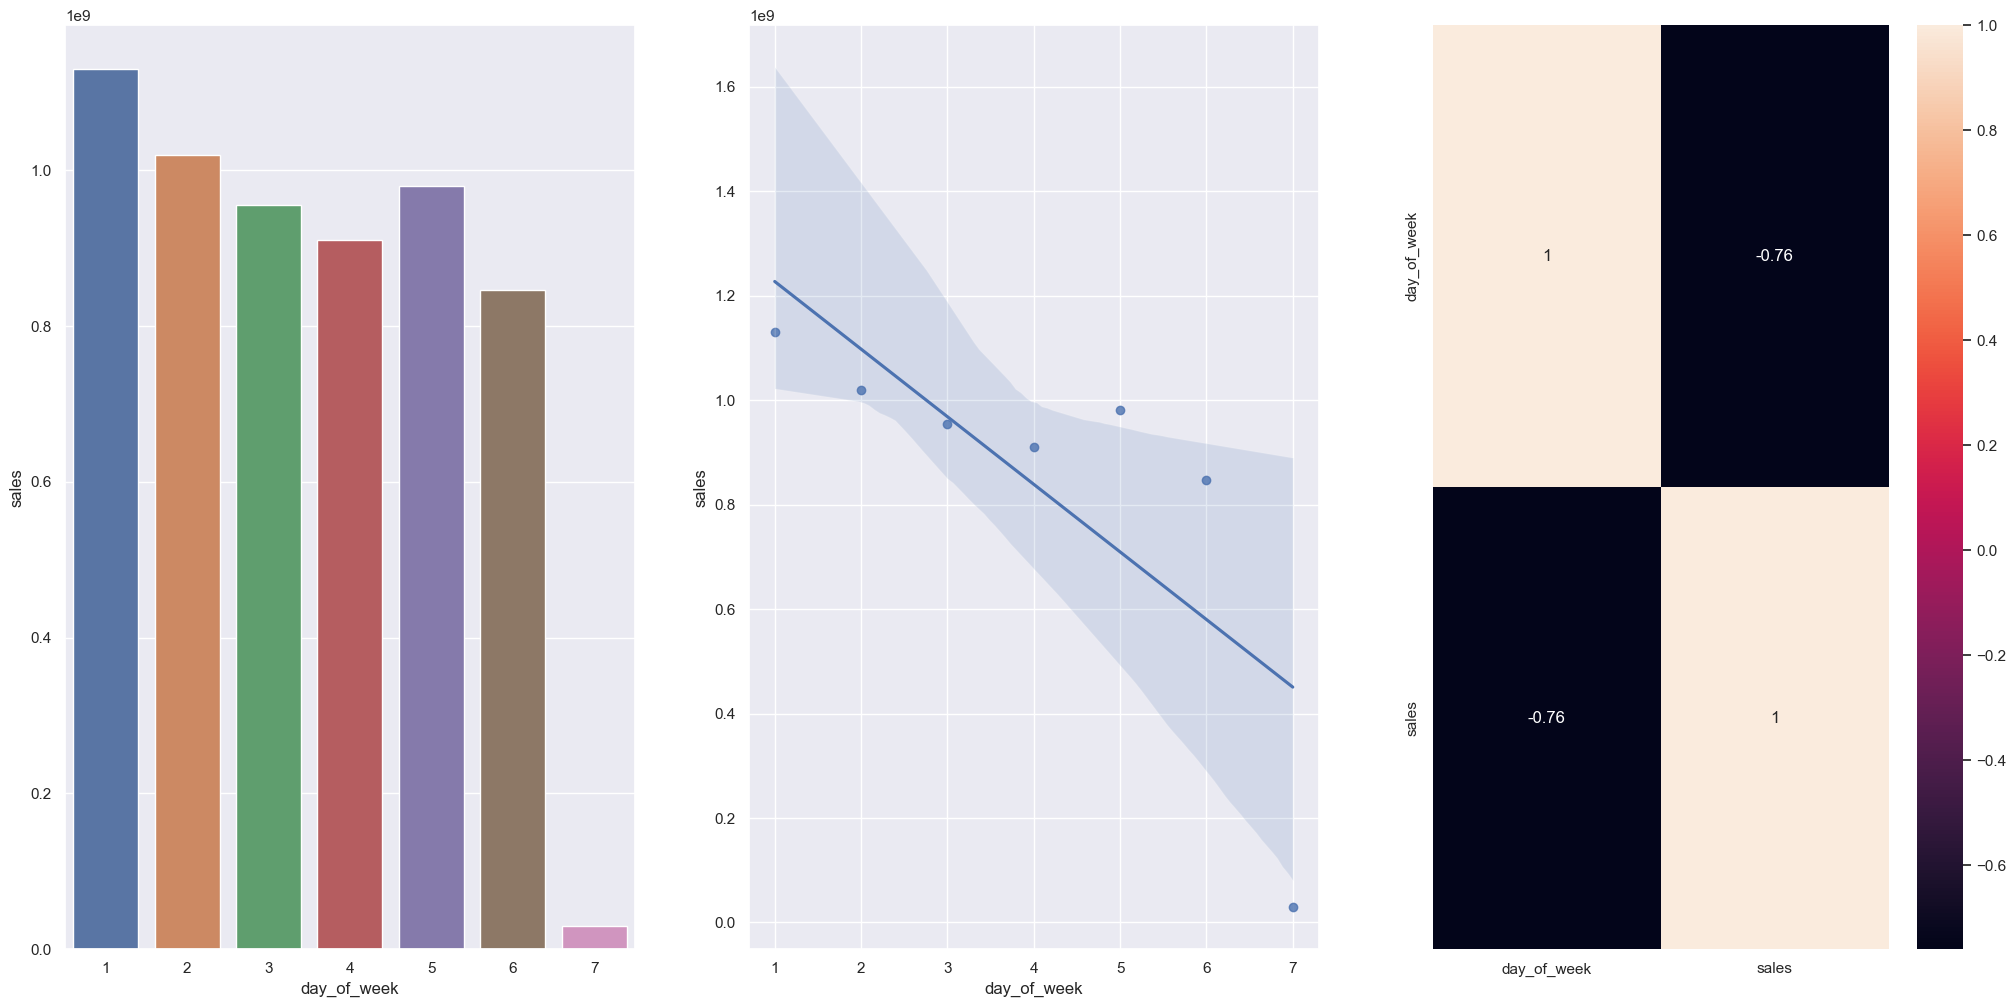

In [38]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( data=aux, x='day_of_week', y='sales');

plt.subplot(1, 3, 2)
sns.regplot( data=aux, x='day_of_week', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux.corr( method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** - Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto

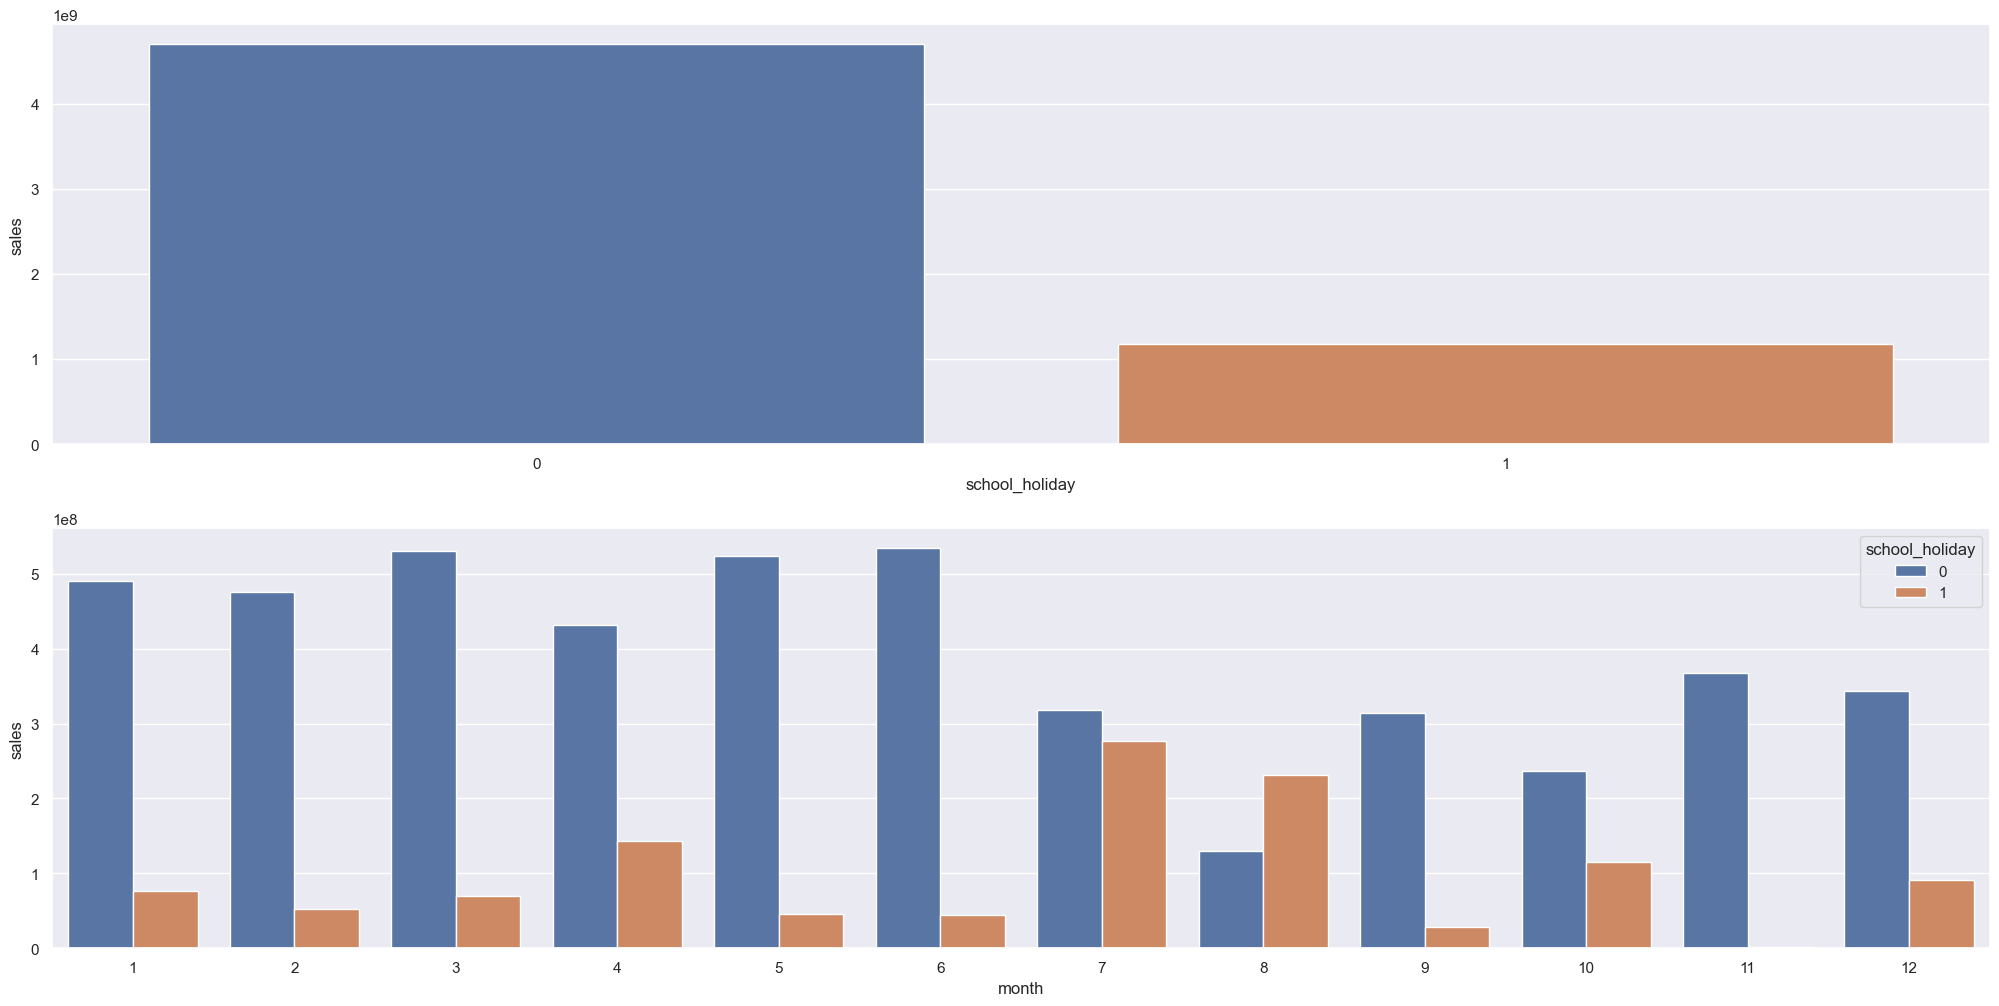

In [39]:
plt.subplot( 2, 1, 1)
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot( data=aux, x='school_holiday', y='sales');

plt.subplot( 2, 1, 2)
aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( data=aux1, x='month', y='sales', hue='school_holiday');


### 4.2.1. Summary of Hypotheses

In [40]:
tab = [
    ['Hipotese', 'Conclusão', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Verdadeira', 'Media'],
    ['H10', 'Falsa', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa'] ]

print( tabulate(tab, headers='firstrow'))

Hipotese    Conclusão    Relevancia
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Media
H8          Falsa        Alta
H9          Verdadeira   Media
H10         Falsa        Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3. Multivariable Analysis

### 4.3.1. Numerical Attributes

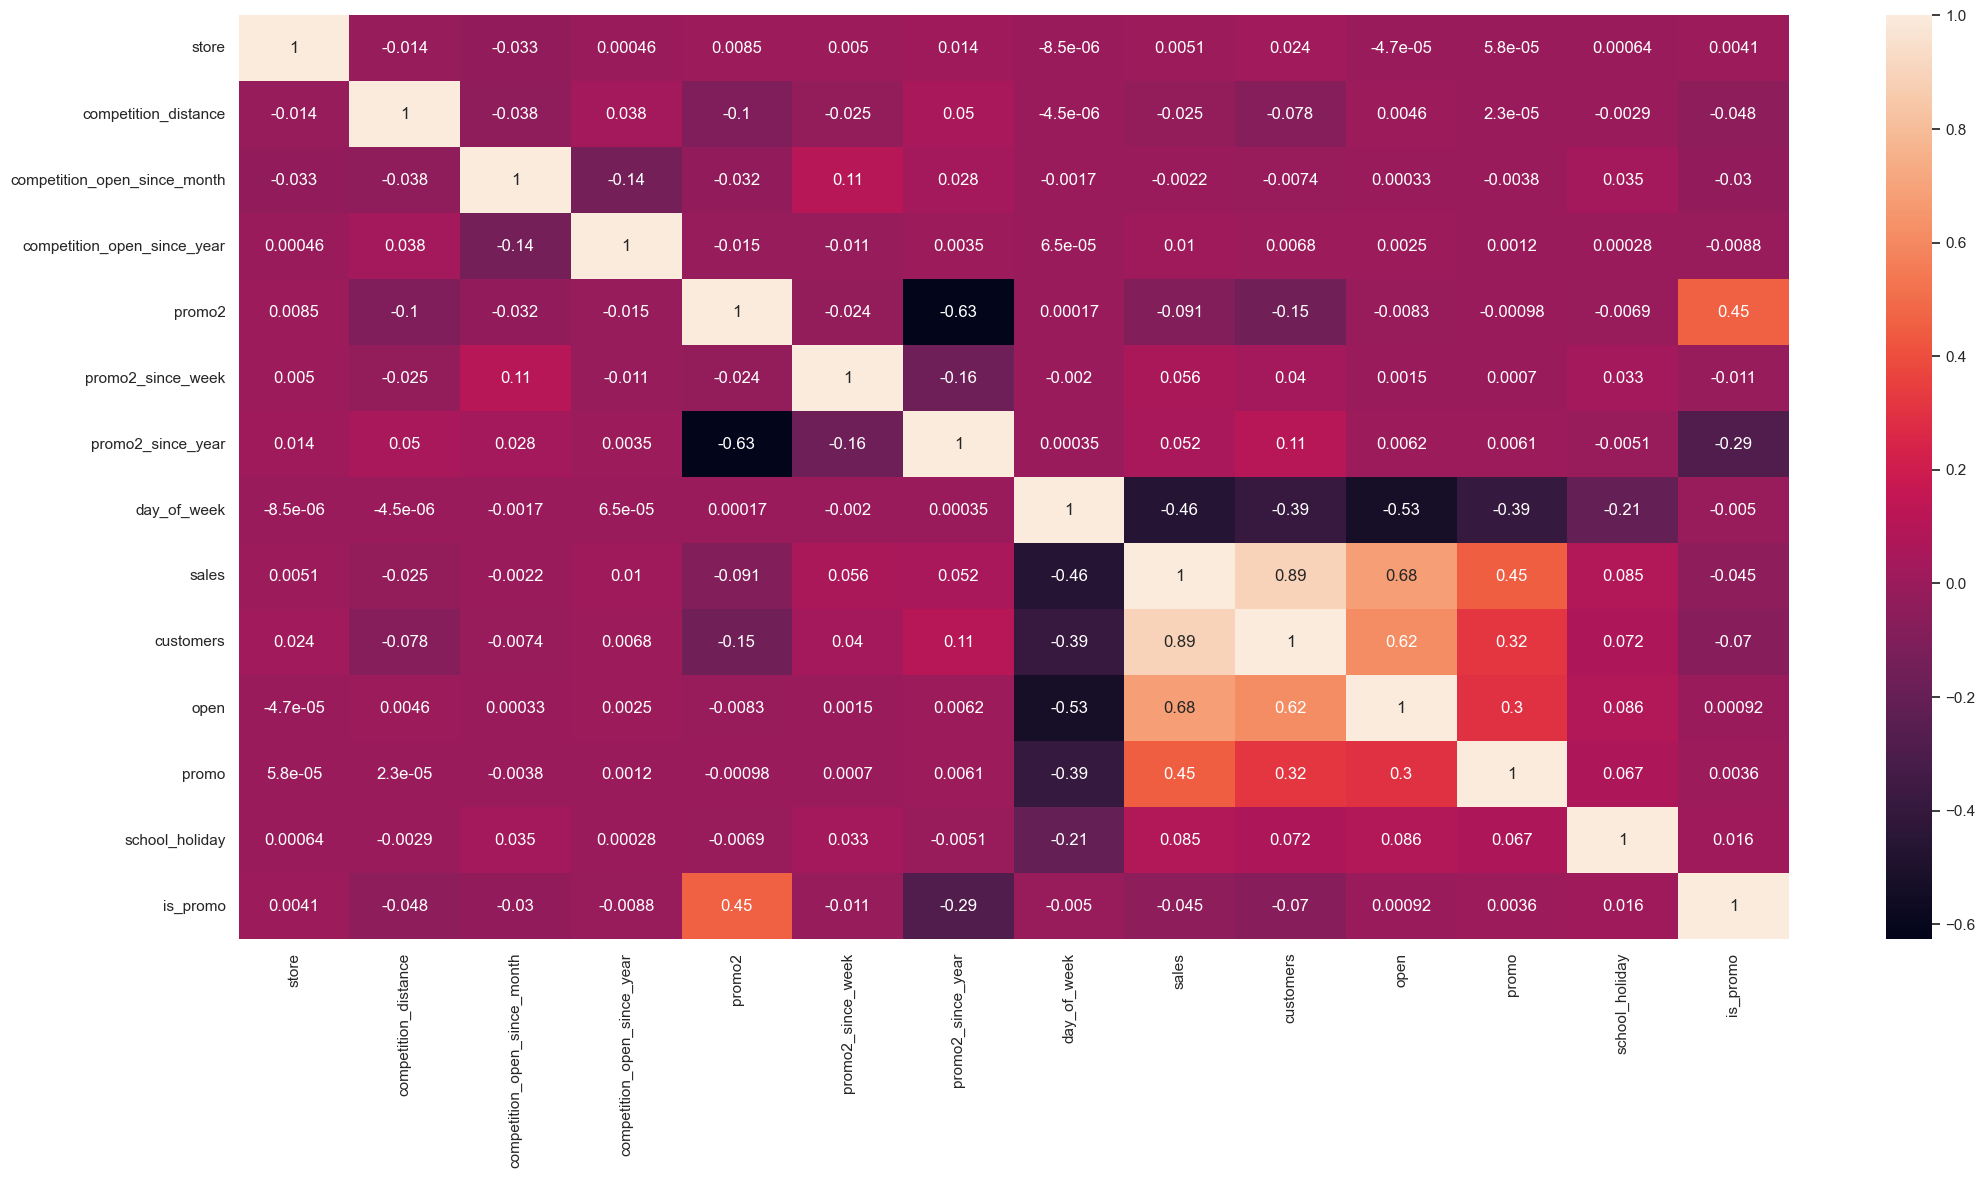

In [41]:
sns.heatmap( num_attributes.corr( method= 'pearson'), annot=True);

### 4.3.1. Categorical Attributes

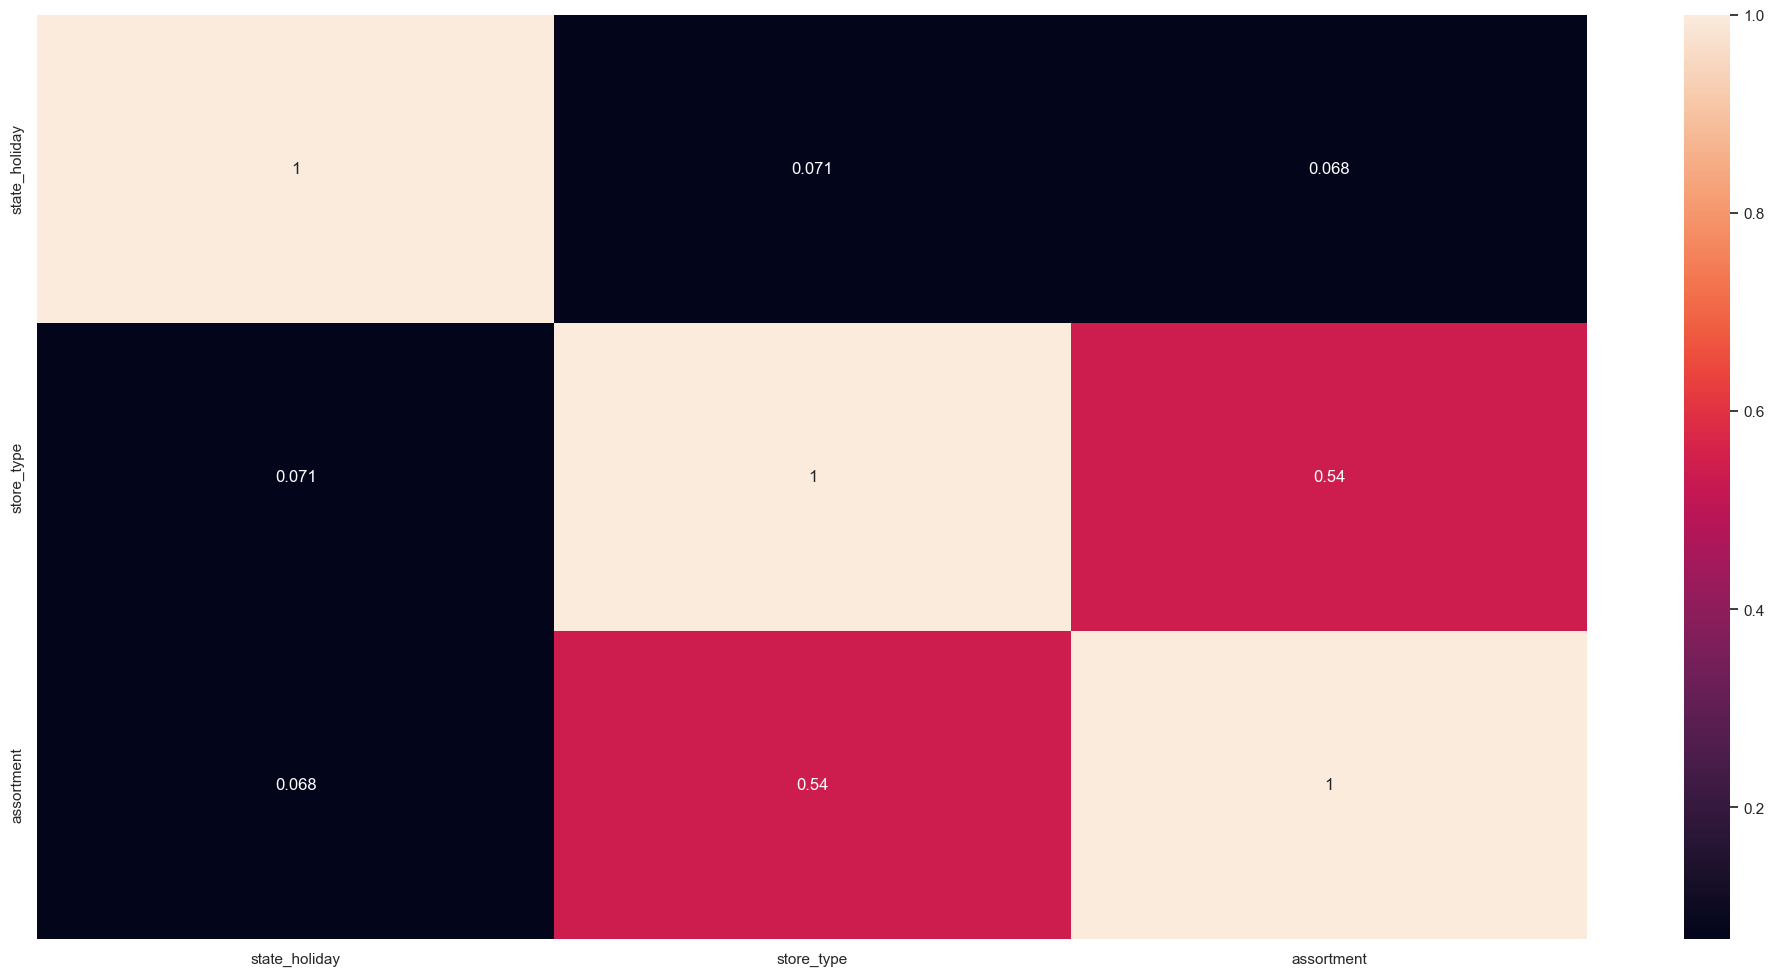

In [42]:
# select categorical data
cat2 = df4.select_dtypes( include= 'object' )

# Calculate cramer V
c1 = cramer_v( cat2['state_holiday'], cat2['state_holiday'] )
c2 = cramer_v( cat2['state_holiday'], cat2['store_type'] )
c3 = cramer_v( cat2['state_holiday'], cat2['assortment'] )

c4 = cramer_v( cat2['store_type'], cat2['state_holiday'] )
c5 = cramer_v( cat2['store_type'], cat2['store_type'] )
c6 = cramer_v( cat2['store_type'], cat2['assortment'] )

c7 = cramer_v( cat2['assortment'], cat2['state_holiday'] )
c8 = cramer_v( cat2['assortment'], cat2['store_type'] )
c9 = cramer_v( cat2['assortment'], cat2['assortment'] )

# Final dataset
d = pd.DataFrame( { 'state_holiday': [c1, c2, c3],
               'store_type': [c4, c5, c6],
               'assortment': [c7, c8, c9] })

d = d.set_index( d.columns )

#heatmap
sns.heatmap( d, annot=True);

# 5.0. STEP 05 - DATA PREPARATION

In [20]:
df5 = df4.copy()

## 5.1. Normalization


In [21]:
# Aplicar para variáveis com distribuição normal

## 5.2. Rescaling


In [22]:
# Aplicar em variáveis NUMÉRICAS com distribuição NÂO NORMAL.
# Min-Max Scaler - (Xi - u) / (Xmax - Xmin ) -> Aplicado para variaveis SEM outliers
# Robust Scaler - (Xi - Q1) / (Q3 - Q1) -> Aplicado para variaveis COM outliers

rs = RobustScaler()
mms = MinMaxScaler()

# competition distance - COM OUTLIER
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'webapp/parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month - COM OUTLIER
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'webapp/parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week - SEM OUTLIER
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'webapp/parameter/promo_time_week_scaler.pkl', 'wb'))

# year - SEM OUTLIER
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'webapp/parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformation


### 5.3.1. Encoding


In [23]:
# Aplicar nas variáveis CATEGÓRICAS para transformá-las em numéricas

# state_holiday - One hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns= ['state_holiday'])

# store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
pickle.dump( le, open( 'webapp/parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation


In [24]:
df5['sales'] = np.log1p( df5['sales'] )

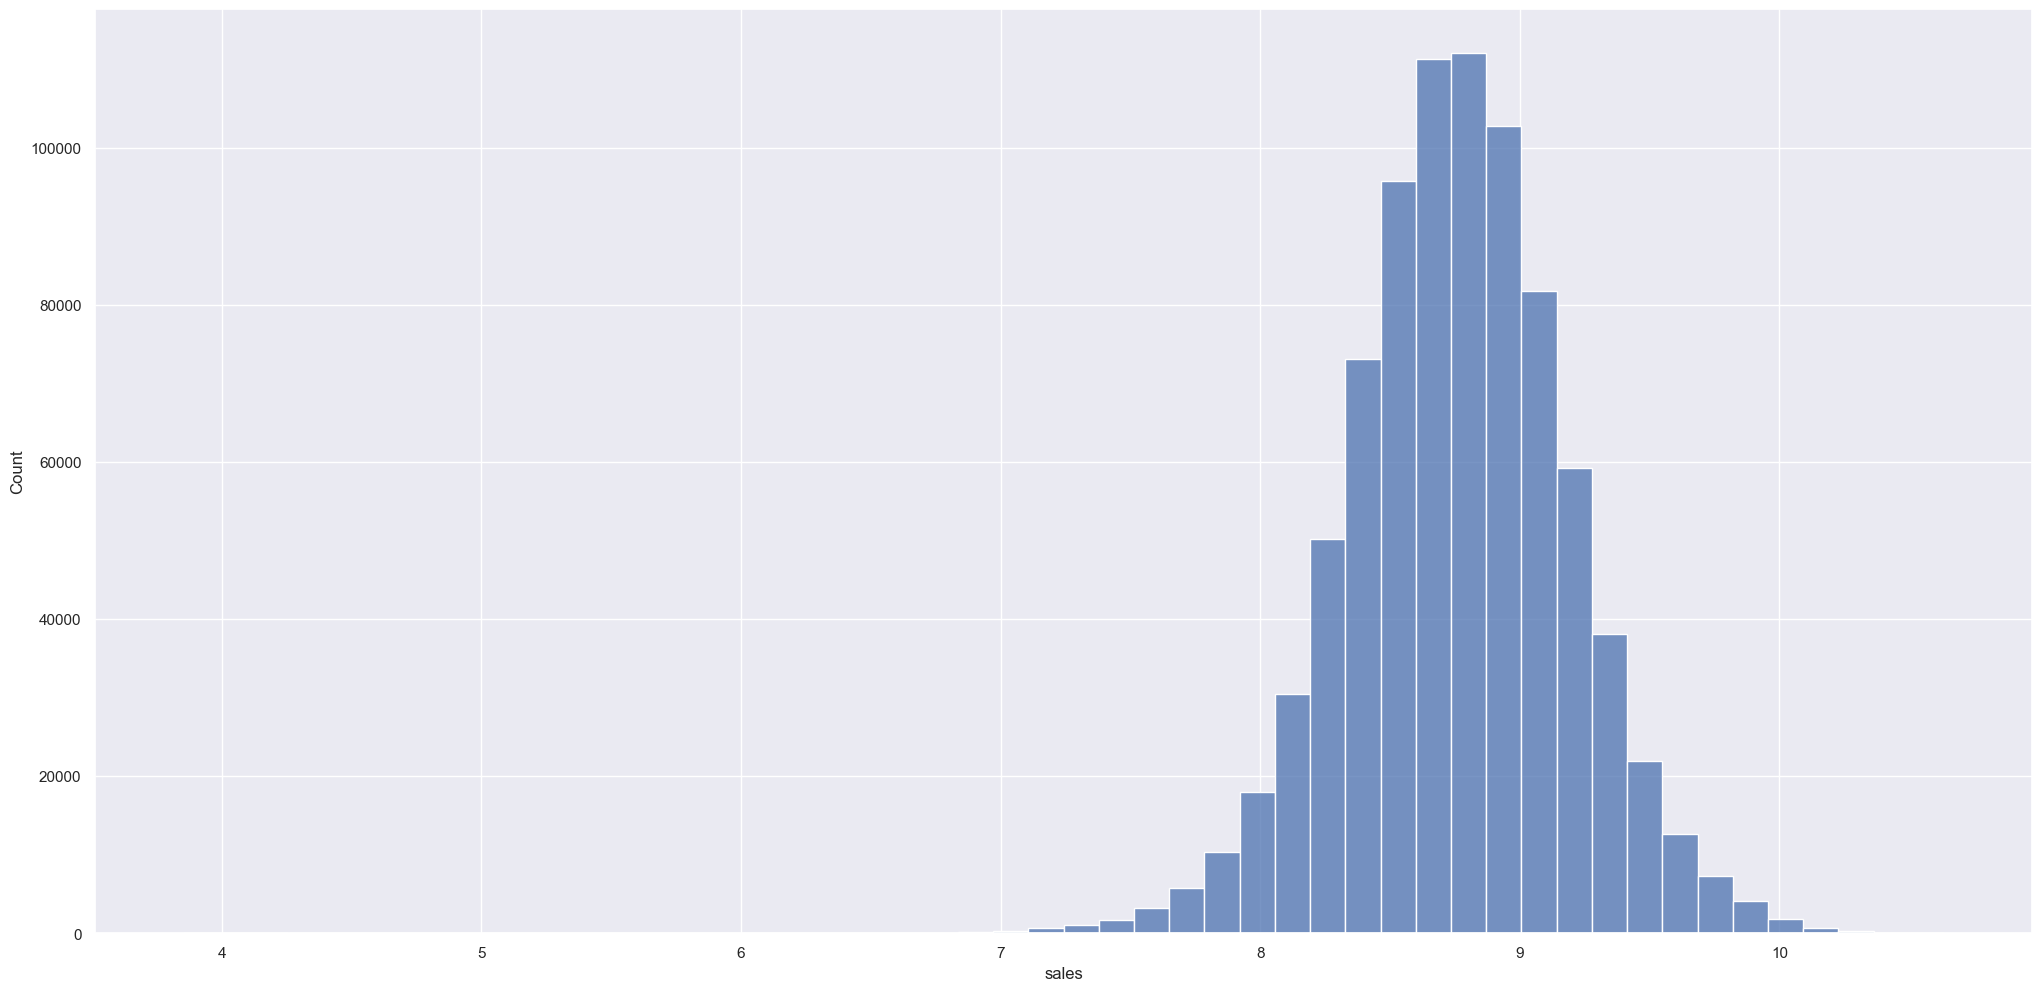

In [25]:
sns.histplot( df5['sales'], bins = 50);

### 5.3.3. Nature Transformation


In [26]:
# Transformar variáveis cíclicas

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52) ) )

In [27]:
df5.head()

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,day_of_week,date,sales,promo,school_holiday,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2,1,-0.170968,9,2008,0,31,2015,5,2015-07-31,8.568646,1,1,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,2.079117e-01,0.978148,-0.568065,-0.822984
1,1,2,1,-0.170968,9,2008,0,31,2015,4,2015-07-30,8.521384,1,1,0,1.0,7,30,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.433884,-0.900969,-0.5,-0.866025,-2.449294e-16,1.000000,-0.568065,-0.822984
2,1,2,1,-0.170968,9,2008,0,31,2015,3,2015-07-29,8.472823,1,1,0,1.0,7,29,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.433884,-0.900969,-0.5,-0.866025,-2.079117e-01,0.978148,-0.568065,-0.822984
3,1,2,1,-0.170968,9,2008,0,31,2015,2,2015-07-28,8.519590,1,1,0,1.0,7,28,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.974928,-0.222521,-0.5,-0.866025,-4.067366e-01,0.913545,-0.568065,-0.822984
4,1,2,1,-0.170968,9,2008,0,31,2015,1,2015-07-27,8.716536,1,1,0,1.0,7,27,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.781831,0.623490,-0.5,-0.866025,-5.877853e-01,0.809017,-0.568065,-0.822984


# 6.0. STEP 06 - FEATURES SELECTIONS

In [28]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset



In [29]:
# Deletar colunas usadas para derivar outras variáveis

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1)

In [30]:
# Separar a data maxima e subtrair 6 semanas (treino)

# Training dataset
X_train = df6[ df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# Test dataset
X_test = df6[ df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print(f'Training min date: {X_train["date"].min()}')
print(f'Training max date: {X_train["date"].max()}')

print(f'\nTest min date: {X_test["date"].min()}')
print(f'Test max date: {X_test["date"].max()}')

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector



In [31]:
# training and test dataset for Boruta
# X_train_n = X_train.drop( ['sales', 'date'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs= -1)

# define Boruta
# boruta = BorutaPy( rf, n_estimators= 'auto', verbose=2, random_state= 42).fit( X_train_n, y_train_n )

### 6.2.1 Best Features from Boruta


In [32]:
# cols_selected= boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected ].columns.to_list()

# # features not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [33]:
cols_selected_boruta = [
    'store',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'promo',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'week_of_year_cos',
    'week_of_year_sin' ]

# columns to add:
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [34]:
x_training = X_train[ cols_selected_boruta_full ]

In [35]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta]

## 7.1. Average Model

In [36]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predicition
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns= {'sales': 'predictions'} )
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [37]:
# model
lr = LinearRegression().fit( x_train, y_train)

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.127229,0.291652,2662.291292


### 7.2.1. Linear Regression Model - Cross Validation


In [ ]:
# lr_result_cv = cross_validation(xtraining, 5, 'Linear Regression', lr)

# lr_result_cv

## 7.3. Linear Regression Regularized Model



In [ ]:
# model
lrr = Lasso( alpha= 0.01).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

### 7.3.1. Lasso - Cross Validation


In [ ]:
# lrr_result_cv = cross_validation(xtraining, 5, 'Lasso', lrr)
# lrr_result_cv

## 7.4. Random Forest Regressor


In [ ]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs= -1, random_state= 42).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

### 7.4.1. Randon Forest Regressor - Cross Validation



In [ ]:
# rf_result_cv = cross_validation(xtraining, 5, 'Random Forest Regressor', rf, verbose=True)
# rf_result_cv


## 7.5. XGBoost Regressor


In [38]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                            n_estimators=100,
                            eta= 0.1,
                            max_depth= 10,
                            subsample= 0.7,
                            colsample_bytree= 0.9).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

C:\Users\samue\anaconda3\envs\rossmann_ds_producao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,856.309298,0.122965,1259.036758


In [39]:
pickle.dump( model_xgb, open( 'webapp/models/model_sem_tuning.pkl', 'wb') )
# model_xgb.save_model( 'webapp/models/model_booster.json')

### 7.5.1. XGBoost Model - Cross Validation



In [65]:
# xgb_result_cv = cross_validation(xtraining, 5, 'XGBoost', model_xgb)
# xgb_result_cv

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [66]:
models_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
models_result.sort_values('RMSE')

NameError: name 'lrr_result' is not defined

### 7.6.2. Real Performance - Cross Validation

In [77]:
# models_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# models_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,846.63 +/- 224.14,0.12 +/- 0.02,1266.11 +/- 326.49
0,XGBoost,1048.77 +/- 174.64,0.14 +/- 0.01,1515.22 +/- 252.73
0,Linear Regression,2090.73 +/- 306.77,0.3 +/- 0.02,2961.34 +/- 481.74
0,Lasso,2132.69 +/- 355.64,0.29 +/- 0.01,3076.06 +/- 520.38


# 8.0. STEP 08 - HYPERPARAMETERS FINE TUNING


## 8.1. Randon Search


In [107]:
warnings.filterwarnings( 'ignore' )

In [86]:
# param = { 'n_estimators': [2000, 2500, 3000, 3500],
#          'eta': [0.1, 0.3], 
#          'max_depth': [4, 7, 10], 
#          'subsample': [0.3, 0.6, 0.9], 
#          'colsample_bytree': [0.2, 0.5, 0.7],
#         'min_child_weight': [3, 8, 15] }

# max_eval = 5

In [87]:
# final_result = pd.DataFrame()

# for i in range( max_eval):
#     # choose the parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
    
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                 n_estimators= hp['n_estimators'],
#                                 eta= hp['eta'],
#                                 max_depth= hp['max_depth'],
#                                 subsample= hp['subsample'],
#                                 colsample_bytree= hp['colsample_bytree'],
#                                 min_child_weight = hp['min_child_weight'] 
#                                 )

#     # performance
#     result = cross_validation( xtraining, 2, 'XGBoost Regressor', model_xgb, verbose=False )
#     final_result = pd.concat( [final_result, result] )

# final_result

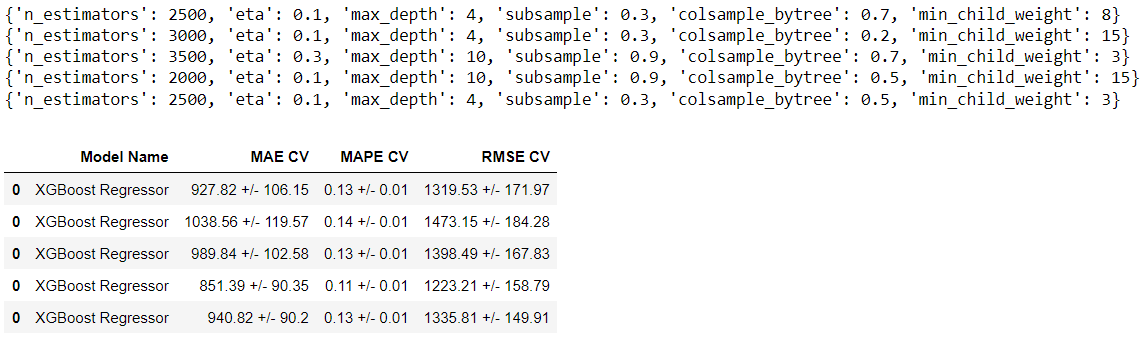

In [88]:
# Image with the fine tuning result
Image( 'img/fine_tuning_result.png')

## 8.2. Final Model

In [75]:
param_tuned = { 'n_estimators': 500 ,
         'eta': 0.1, 
         'max_depth': 10 , 
         'subsample': 0.9, 
         'colsample_bytree': 0.5,
         'min_child_weight': 15 }

In [76]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators= param_tuned['n_estimators'],
                                    eta= param_tuned['eta'],
                                    max_depth= param_tuned['max_depth'],
                                    subsample= param_tuned['subsample'],
                                    colsample_bytree= param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight'] 
                                    ).fit( x_train, y_train )

# predict
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned


C:\Users\samue\anaconda3\envs\rossmann_ds_producao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,640.476622,0.09276,932.014145


# 9.0. STEP 09 - ERROR TRASLATION AND INTERPRETATION

In [110]:
df9 = X_test[ cols_selected_boruta_full ].copy()

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [111]:
# sum of predictions
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'],
                                                  x['predictions']) ).reset_index().rename( columns= {0: 'MAE'} )

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'],
                                                  x['predictions']) ).reset_index().rename( columns= {0: 'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df9_2 = pd.merge( df9_1, df9_aux3, how='inner', on='store')

# Scenarios
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# order columns
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df9_2.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,158737.734375,158453.204794,159022.263956,284.529581,0.063683
1,2,178091.562500,177731.357824,178451.767176,360.204676,0.075944
2,3,261761.171875,261151.220004,262371.123746,609.951871,0.087351
3,4,333817.437500,332802.886969,334831.988031,1014.550531,0.097570
4,5,167300.421875,166957.847587,167642.996163,342.574288,0.080065


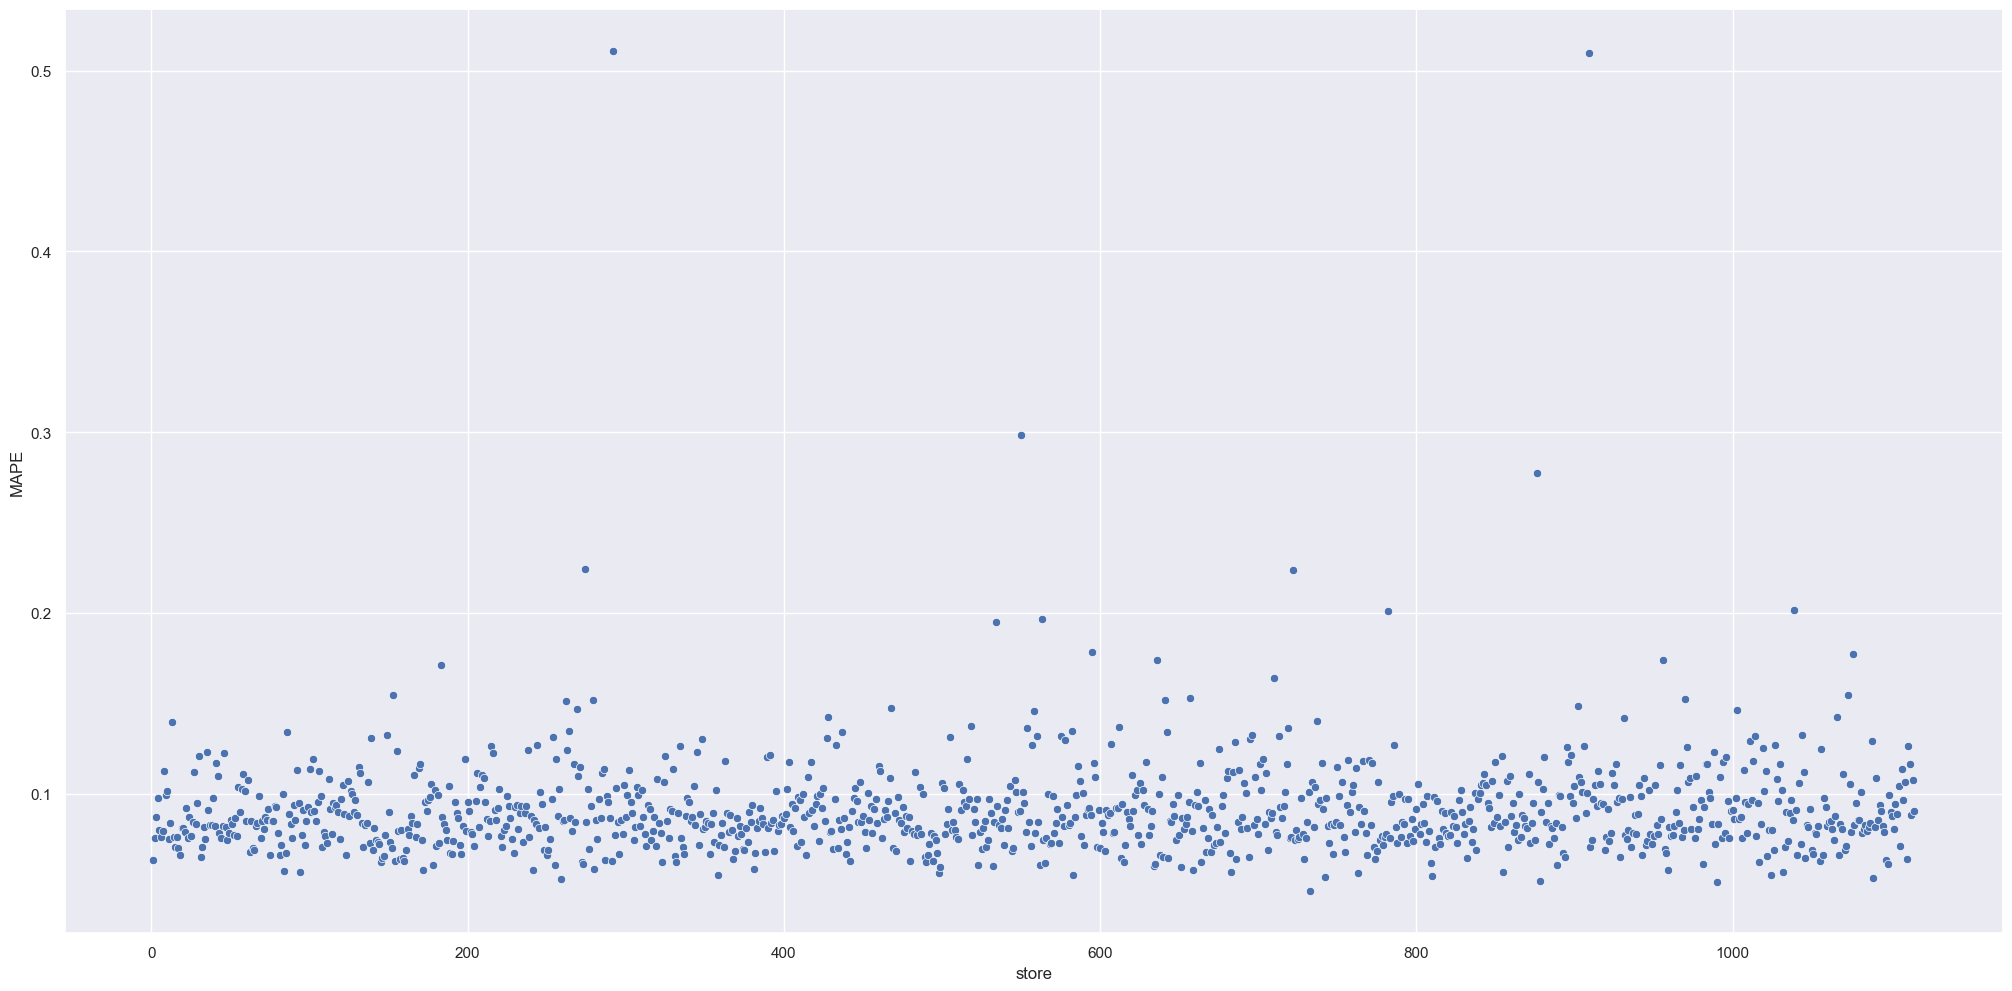

In [112]:
sns.scatterplot( data= df9_2, x='store', y='MAPE');

## 9.2. Total Performance

In [113]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns= {'index': 'Scenario', 0: 'Values'} )

df9_3['Values'] = df9_3['Values'].map( 'R${:,.2f}'.format ) 
df9_3

,Scenario,Values
0,predictions,"R$282,113,088.00"
1,worst_scenario,"R$281,406,718.67"
2,best_scenario,"R$282,819,460.65"


## 9.3. Machine Learning Performance

In [81]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\samue\AppData\Local\Temp\ipykernel_3680\1404839629.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df9['error'] );


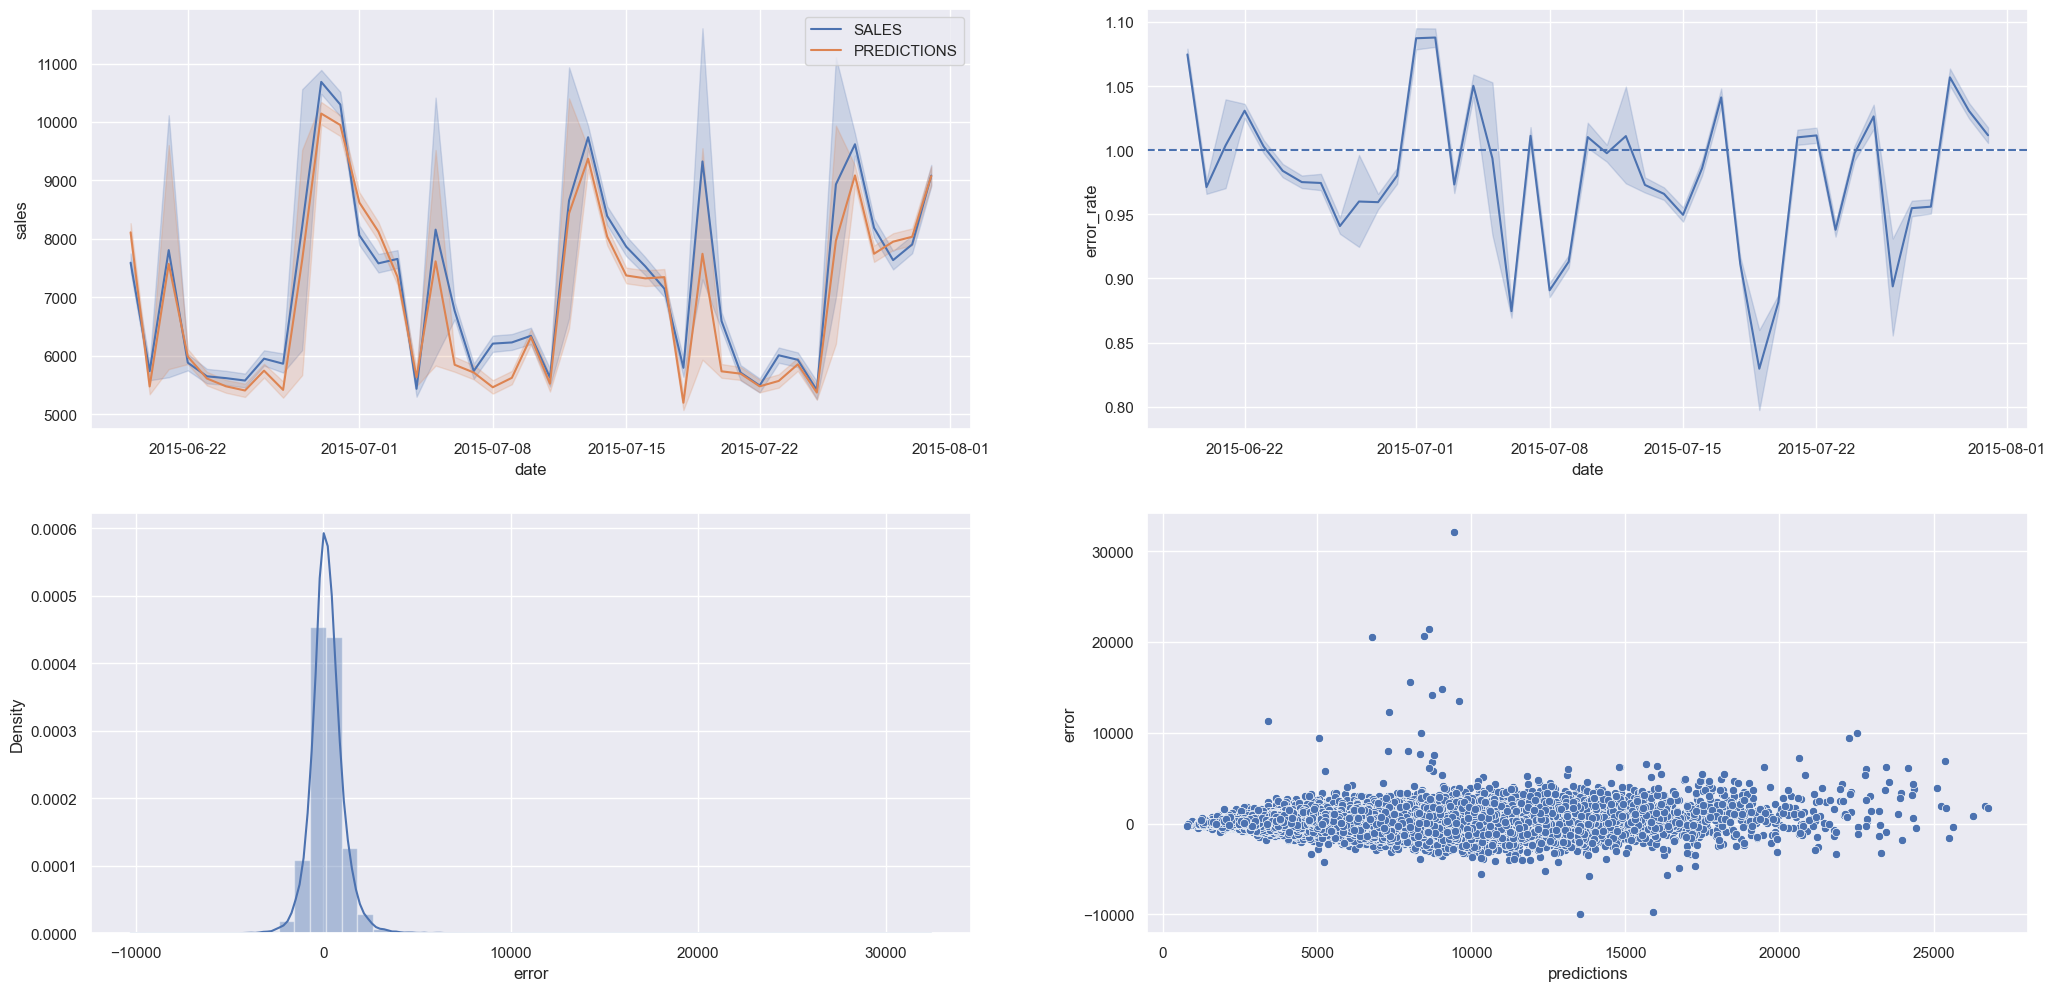

In [82]:
plt.subplot( 2, 2, 1)
sns.lineplot( data= df9, x='date', y='sales', label= 'SALES');
sns.lineplot( data= df9, x='date', y='predictions', label= 'PREDICTIONS');

plt.subplot( 2, 2, 2)
sns.lineplot( data= df9, x='date', y='error_rate');
plt.axhline( 1, linestyle= '--')

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'] );

plt.subplot( 2, 2, 4)
sns.scatterplot( x= df9['predictions'], y= df9['error'] );


# 10.0. STEP 10 - DEPLOY MODEL TO PRODUCTION

In [77]:
# Salvando modelo treinado
# pickle.dump( model_xgb_tuned, open( 'webapp/models/model_n500.pkl', 'wb') )

## 10.1. Rossmann Class


In [50]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

class Rossmann:
    def __init__(self):
        self.competition_distance_scaler    = pickle.load( open( 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler  = pickle.load( open( 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler         = pickle.load( open( 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                    = pickle.load( open( 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load( open( 'parameter/store_type_scaler.pkl', 'rb'))

        
        
    def data_cleaning( self, df1 ):
        
        # 1.1 Rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
        'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        new_cols = list( map( snakecase, cols_old) )

        #rename
        df1.columns = new_cols

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime( df1['date'] )


        ## 1.5 Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x )

        # competition_open_since_month
        df1['competition_open_since_month'] = ( df1.apply( lambda x: x['date'].month if math.isnan( 
            x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) )

        # competition_open_since_year
        df1['competition_open_since_year'] = ( df1.apply( lambda x: x['date'].year if math.isnan( 
            x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 ) )
        
        # promo2_since_week
        df1['promo2_since_week'] = ( df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else 
                                             x['promo2_since_week'], axis=1 ) ) 

        # promo2_since_year
        df1['promo2_since_year'] = ( df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else 
                                             x['promo2_since_year'], axis=1 ) )

        # promo_interval
        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec' }

        df1['promo_interval'] = df1['promo_interval'].fillna(0)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = ( df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if 
                                                                     x['month_map'] in x['promo_interval'] else 0, axis=1 ) )


        ## 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )
        
        return df1
    
    
    
    def feature_engineering( self, df2):

        ## 2.3. Feature Engineering
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = ( df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'] ,
                                                                            month= x['competition_open_since_month'], day=1 ), axis=1 ) )

        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )

        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) / 7).apply( lambda x: x.days ).astype( 'int64' )                 

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')               

        # state holiday
        df2['state_holiday'] = ( df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) )


        # 3.0. STEP 03 - FILTERING VARIABLES
        ## 3.1. Rows Filtering
        df2 = df2[ df2['open'] != 0 ]

        ## 3.2. Columns Filtering
        cols_drop = [ 'open', 'month_map', 'promo_interval']
        df2 = df2.drop( cols_drop, axis=1)
        
        return df2

    
    
    def data_preparation(self, df5):

        ## 5.2. Rescaling
        # competition distance - COM OUTLIER
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )

        # competition time month - COM OUTLIER
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week - SEM OUTLIER
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year - SEM OUTLIER
        df5['year'] = self.year_scaler.fit( df5[['year']].values )


        ## 5.3. Transformation

        ### 5.3.1. Encoding

        # state_holiday - One hot encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns= ['state_holiday'])

        # store_type - Label encoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nuture Transformation
        # Transformar variáveis cíclicas
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52) ) )

        cols_selected = ['store', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo', 
                         'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 
                         'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos', 'week_of_year_sin' ]
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient= 'records', date_format= 'iso' ) 

## 10.2. API Handler


In [ ]:
import json
import pickle
import pandas as pd
from rossmann.Rossmann import Rossmann
from flask import Flask, request, Response

# loading model
model = pickle.load( open( 'model/model_ok.pkl', 'rb'))

# Initialize API
app = Flask( __name__ )

@app.route( '/predict', methods= ['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: 
        if isinstance( test_json, dict ): #unique example
            test_raw = pd.DataFrame( test_json, index= [0] )
        
        else: #multiple example
            test_raw = pd.DataFrame( test_json, columns= test_json[0].keys() )
            
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3)
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype= 'application/json')

if __name__ == '__main__':
    app.run( '0.0.0.0', debug= True)

## 10.3. API Tester


In [5]:
# Loading test dataset
df10 = pd.read_csv(r'C:/Users/samue/Documents/repos/ds_em_producao/data/test.csv')
df_store_raw = pd.read_csv( r'C:/Users/samue/Documents/repos/ds_em_producao/data/store.csv' )

In [16]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how= 'left', on= 'Store')

# Choose store for prediction
df_test = df_test[ df_test['Store'].isin( [10, 98, 254, 574]) ]

# remove closed days
df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis=1 )

In [17]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( 'recors'))

C:\Users\samue\AppData\Local\Temp\ipykernel_20376\1964607781.py:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  data = json.dumps( df_test.to_dict( 'recors'))


In [18]:
# API Call
# url= 'http://192.168.0.11:5000/predict'
url = 'https://webapp-rossmann.onrender.com/predict'

header= {'Content-type': 'application/json'}

data= data

r = requests.post( url, data= data, headers= header)
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [19]:
df = pd.DataFrame( r.json(), columns= r.json()[0].keys() )

In [20]:
df2 = df[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len( df2)):
    print(f'Store number { df2.loc[i, "store"] } will sell R${ df2.loc[i, "prediction"] :,.2f} in the next 6 weeks')

Store number 10 will sell R$221,169.19 in the next 6 weeks
Store number 98 will sell R$218,507.62 in the next 6 weeks
Store number 254 will sell R$129,546.10 in the next 6 weeks
Store number 574 will sell R$318,992.70 in the next 6 weeks
